In [ ]:
#@title check GPU type
!nvidia-smi

Mon Mar 14 01:11:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title import libraries
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold, train_test_split
torch.manual_seed(1)    # reproducible torch:2 np:3
np.random.seed(1)

%cd /content/drive/MyDrive/Proj4_DPI/scripts/model3_TransDTI/
from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/content/drive/MyDrive/Proj4_DPI/scripts/model3_TransDTI


In [3]:
#@title define functions
def test(data_generator, model, use_cuda):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, label) in enumerate(data_generator):

        label = Variable(torch.from_numpy(np.array(label)).float())
        if use_cuda:
            d = d.cuda()
            p = p.cuda()
            label = label.cuda()
        
        score = model(d, p)
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()           

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    # thred_optim = thresholds[5:][np.argmax(f1[5:])]
    thred_optim = 0.5

    print("optimal threshold: " + str(thred_optim))

    # y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]
    y_pred_s = [1 if i>=thred_optim else 0 for i in y_pred]
    

    auc_k = metrics.auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return accuracy1, roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()

def main(use_cuda):
    config = BIN_config_DBPE()
    
    lr = config['learning_rate']
    BATCH_SIZE = config['batch_size']
    # BATCH_SIZE = 128
    train_epoch = config['train_epoch']
    accumulation_steps = config['accumulation_steps']

    print("learning rate:",lr)
    print("batch size:",BATCH_SIZE)
    print("training epoch:",train_epoch)
    print("accumulation steps:", accumulation_steps)

    
    loss_history = []
    loss_history_val = []
    acc_train = []
    acc_val = []
    
    model = BIN_Interaction_Flat(**config)
    
    if use_cuda:
        model = model.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
    elif torch.cuda.device_count() < 1:
        print("Let's use cpu!")
            
    opt = torch.optim.AdamW(model.parameters(), lr = lr)
    # opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
    # df_train = pd.read_pickle(dataFolder + '/train_loc0.pkl')
    # df_train = df_train[1:1000]
    # df_val = pd.read_pickle(dataFolder + '/val_loc0.pkl')
    # df_val = df_val[1:500]
    # df_test = pd.read_pickle(dataFolder + '/test_loc0.pkl')
    # df_test = df_test[1:500]
    # df = pd.read_pickle(dataFolder + '/JUNB_test.pkl')
    df = pd.read_pickle(dataFolder + '/AP2A_train.pkl')
    
    df_train, df_val = train_test_split(df, test_size=0.2)
    print("training size: ", df_train.shape[0])
    print("validation size: ", df_val.shape[0])
  

    training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(np.array([i for i in range(df_val.shape[0])]), df_val.label.values, df_val)
    validation_generator = data.DataLoader(validation_set, **params)
    # testing_set = BIN_Data_Encoder(np.array([i for i in range(df_test.shape[0])]), df_test.label.values, df_test)
    # testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, label) in enumerate(training_generator):
            
            label = Variable(torch.from_numpy(np.array(label)).float())
            if use_cuda:
                d = d.cuda()
                p = p.cuda()
                label = label.cuda()

            
            score = model(d, p)
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            # print(d.isnan().any())
            # print(p.isnan().any())
            # print(p)
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            loss.backward()
            

            # only updates weights after gradients are accumulated
            if ((i+1) % accumulation_steps == 0):
                opt.step()
                opt.zero_grad()
            
            if ((i+1) % 100 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i+1) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            accuracy, auc, auprc, f1, logits, loss = test(validation_generator, model, use_cuda)
            loss_history_val.append(loss)
            acc_val.append(accuracy)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
                # # save the model
                # save_path = './epoch' + str(epo+1) + '.pt'
                # torch.save(model.state_dict(), save_path)
                # print('Saving model to',save_path)

            print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Val loss: '+str(loss)+ ' , Accuracy: '+str(accuracy))
            
            accuracy, auc, auprc, f1, logits, loss = test(training_generator, model, use_cuda)
            print('Training at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Train loss: '+str(loss)+ ' , Accuracy: '+str(accuracy))
            acc_train.append(accuracy)

    print("max validation accuracy "+ str(max_auc))
    # print('--- Go for Testing ---')
    # try:
    #     with torch.set_grad_enabled(False):
    #         auc, auprc, f1, logits, loss = test(testing_generator, model_max, use_cuda)
    #         print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    # except:
    #     print('testing failed')
    return model_max, model, loss_history, loss_history_val, acc_train, acc_val


In [4]:
#@title run the model
s = time()
model_max, model_last, loss_history, loss_val, acc_train, acc_val = main(use_cuda)
e = time()
print(e-s)

learning rate: 0.001
batch size: 64
training epoch: 100
accumulation steps: 1
--- Data Preparation ---
training size:  23660
validation size:  5916
--- Go for Training ---
Training at Epoch 1 iteration 100 with loss 0.702685
Training at Epoch 1 iteration 200 with loss 0.682441
Training at Epoch 1 iteration 300 with loss 0.67854583
optimal threshold: 0.5
AUROC:0.5779963988579269
AUPRC: 0.5661722717568693
Confusion Matrix : 
 [[1727 1238]
 [1373 1550]]
Recall :  0.5302771125555936
Precision :  0.5559540889526542
Accuracy :  0.5565557065217391
Sensitivity :  0.5824620573355818
Specificity :  0.5302771125555936
Validation at Epoch 1 , AUROC: 0.5779963988579269 , AUPRC: 0.5661722717568693 , F1: 0.5428121169672562 , Val loss: 0.6837907433509827 , Accuracy: 0.5565557065217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6013117805909598
AUPRC: 0.5925178754880669
Confusion Matrix : 
 [[6898 4825]
 [5246 6647]]
Recall :  0.5589001933910703
Precision :  0.5794107391910739
Accuracy :  0.5735518292682927
Sensitivity :  0.5884159344877591
Specificity :  0.5589001933910703
Training at Epoch 1 , AUROC: 0.6013117805909598 , AUPRC: 0.5925178754880669 , F1: 0.5689706826449819 , Train loss: 0.6779308319091797 , Accuracy: 0.5735518292682927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 2 iteration 100 with loss 0.69159234
Training at Epoch 2 iteration 200 with loss 0.6931017
Training at Epoch 2 iteration 300 with loss 0.70079726
optimal threshold: 0.5
AUROC:0.5939828278264256
AUPRC: 0.5749033119089637
Confusion Matrix : 
 [[1774 1188]
 [1372 1554]]
Recall :  0.5311004784688995
Precision :  0.5667396061269147
Accuracy :  0.5652173913043478
Sensitivity :  0.5989196488858879
Specificity :  0.5311004784688995
Validation at Epoch 2 , AUROC: 0.5939828278264256 , AUPRC: 0.5749033119089637 , F1: 0.5483415666901906 , Val loss: 0.6805067658424377 , Accuracy: 0.5652173913043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.619189194562733
AUPRC: 0.6076557146387489
Confusion Matrix : 
 [[7175 4549]
 [5281 6611]]
Recall :  0.5559199461823074
Precision :  0.5923835125448028
Accuracy :  0.5837567750677507
Sensitivity :  0.6119924940293415
Specificity :  0.5559199461823074
Training at Epoch 2 , AUROC: 0.619189194562733 , AUPRC: 0.6076557146387489 , F1: 0.5735727919486378 , Train loss: 0.6746813058853149 , Accuracy: 0.5837567750677507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 3 iteration 100 with loss 0.68774545
Training at Epoch 3 iteration 200 with loss 0.6776068
Training at Epoch 3 iteration 300 with loss 0.67422533
optimal threshold: 0.5
AUROC:0.5945015306666396
AUPRC: 0.5792573940616179
Confusion Matrix : 
 [[1527 1435]
 [1078 1848]]
Recall :  0.631578947368421
Precision :  0.5628997867803838
Accuracy :  0.5731997282608695
Sensitivity :  0.5155300472653612
Specificity :  0.631578947368421
Validation at Epoch 3 , AUROC: 0.5945015306666396 , AUPRC: 0.5792573940616179 , F1: 0.5952649379932357 , Val loss: 0.6799311637878418 , Accuracy: 0.5731997282608695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6320904750156651
AUPRC: 0.624682923023395
Confusion Matrix : 
 [[6220 5509]
 [4101 7786]]
Recall :  0.655001261882729
Precision :  0.5856336968785257
Accuracy :  0.5930724932249323
Sensitivity :  0.5303094893000255
Specificity :  0.655001261882729
Training at Epoch 3 , AUROC: 0.6320904750156651 , AUPRC: 0.624682923023395 , F1: 0.6183782066555475 , Train loss: 0.6680349111557007 , Accuracy: 0.5930724932249323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 4 iteration 100 with loss 0.6620066
Training at Epoch 4 iteration 200 with loss 0.68542314
Training at Epoch 4 iteration 300 with loss 0.68755436
optimal threshold: 0.5
AUROC:0.5955890429609527
AUPRC: 0.5812419700927062
Confusion Matrix : 
 [[1515 1443]
 [1097 1833]]
Recall :  0.6255972696245734
Precision :  0.5595238095238095
Accuracy :  0.5686141304347826
Sensitivity :  0.5121703853955375
Specificity :  0.6255972696245734
Validation at Epoch 4 , AUROC: 0.5955890429609527 , AUPRC: 0.5812419700927062 , F1: 0.5907186593619078 , Val loss: 0.6800546050071716 , Accuracy: 0.5686141304347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6484157753847686
AUPRC: 0.6396455628247661
Confusion Matrix : 
 [[6316 5414]
 [3968 7918]]
Recall :  0.6661618711088676
Precision :  0.5939093909390939
Accuracy :  0.6027269647696477
Sensitivity :  0.5384484228473998
Specificity :  0.6661618711088676
Training at Epoch 4 , AUROC: 0.6484157753847686 , AUPRC: 0.6396455628247661 , F1: 0.6279641525894203 , Train loss: 0.6639013886451721 , Accuracy: 0.6027269647696477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 5 iteration 100 with loss 0.64714503
Training at Epoch 5 iteration 200 with loss 0.6909393
Training at Epoch 5 iteration 300 with loss 0.6412692
optimal threshold: 0.5
AUROC:0.5920366942159441
AUPRC: 0.5745594135981721
Confusion Matrix : 
 [[1496 1470]
 [1094 1828]]
Recall :  0.6255989048596852
Precision :  0.5542753183747726
Accuracy :  0.5645380434782609
Sensitivity :  0.5043830074173972
Specificity :  0.6255989048596852
Validation at Epoch 5 , AUROC: 0.5920366942159441 , AUPRC: 0.5745594135981721 , F1: 0.5877813504823151 , Val loss: 0.6803505420684814 , Accuracy: 0.5645380434782609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6482106268340593
AUPRC: 0.6414120137210058
Confusion Matrix : 
 [[6422 5295]
 [4053 7846]]
Recall :  0.6593831414404572
Precision :  0.5970626284148847
Accuracy :  0.6041666666666666
Sensitivity :  0.5480925151489289
Specificity :  0.6593831414404572
Training at Epoch 5 , AUROC: 0.6482106268340593 , AUPRC: 0.6414120137210058 , F1: 0.6266773162939296 , Train loss: 0.6623469591140747 , Accuracy: 0.6041666666666666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 6 iteration 100 with loss 0.6861084
Training at Epoch 6 iteration 200 with loss 0.6905242
Training at Epoch 6 iteration 300 with loss 0.64105964
optimal threshold: 0.5
AUROC:0.5948972355694343
AUPRC: 0.5761253854087911
Confusion Matrix : 
 [[1420 1542]
 [ 993 1933]]
Recall :  0.6606288448393711
Precision :  0.5562589928057554
Accuracy :  0.5694633152173914
Sensitivity :  0.47940580688723833
Specificity :  0.6606288448393711
Validation at Epoch 6 , AUROC: 0.5948972355694343 , AUPRC: 0.5761253854087911 , F1: 0.6039681299796907 , Val loss: 0.6824377179145813 , Accuracy: 0.5694633152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6587811111543929
AUPRC: 0.6501679689695224
Confusion Matrix : 
 [[6063 5666]
 [3518 8369]]
Recall :  0.7040464372844284
Precision :  0.5962949768436052
Accuracy :  0.6111111111111112
Sensitivity :  0.5169238639270185
Specificity :  0.7040464372844284
Training at Epoch 6 , AUROC: 0.6587811111543929 , AUPRC: 0.6501679689695224 , F1: 0.6457063498186868 , Train loss: 0.6571359038352966 , Accuracy: 0.6111111111111112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 7 iteration 100 with loss 0.6442652
Training at Epoch 7 iteration 200 with loss 0.6686665
Training at Epoch 7 iteration 300 with loss 0.6617632
optimal threshold: 0.5
AUROC:0.5942756677079998
AUPRC: 0.5793864986346571
Confusion Matrix : 
 [[1593 1370]
 [1165 1760]]
Recall :  0.6017094017094017
Precision :  0.5623003194888179
Accuracy :  0.5694633152173914
Sensitivity :  0.5376307796152549
Specificity :  0.6017094017094017
Validation at Epoch 7 , AUROC: 0.5942756677079998 , AUPRC: 0.5793864986346571 , F1: 0.5813377374071016 , Val loss: 0.6838181018829346 , Accuracy: 0.5694633152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6713562828071786
AUPRC: 0.6638071224916984
Confusion Matrix : 
 [[6882 4840]
 [4050 7844]]
Recall :  0.6594921809315621
Precision :  0.6184169031851151
Accuracy :  0.6235602981029811
Sensitivity :  0.5871011772735029
Specificity :  0.6594921809315621
Training at Epoch 7 , AUROC: 0.6713562828071786 , AUPRC: 0.6638071224916984 , F1: 0.6382944096346326 , Train loss: 0.6485931873321533 , Accuracy: 0.6235602981029811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 8 iteration 100 with loss 0.7125484
Training at Epoch 8 iteration 200 with loss 0.6547164
Training at Epoch 8 iteration 300 with loss 0.6742514
optimal threshold: 0.5
AUROC:0.5961476599584167
AUPRC: 0.5795749019885177
Confusion Matrix : 
 [[1448 1510]
 [1033 1897]]
Recall :  0.6474402730375427
Precision :  0.5567948341649545
Accuracy :  0.5681046195652174
Sensitivity :  0.48951994590939824
Specificity :  0.6474402730375427
Validation at Epoch 8 , AUROC: 0.5961476599584167 , AUPRC: 0.5795749019885177 , F1: 0.5987060123086633 , Val loss: 0.688487708568573 , Accuracy: 0.5681046195652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6746736780231684
AUPRC: 0.6648814563679211
Confusion Matrix : 
 [[6247 5477]
 [3479 8413]]
Recall :  0.7074503868146653
Precision :  0.6056875449964003
Accuracy :  0.6207655826558266
Sensitivity :  0.5328386216308427
Specificity :  0.7074503868146653
Training at Epoch 8 , AUROC: 0.6746736780231684 , AUPRC: 0.6648814563679211 , F1: 0.6526258630051974 , Train loss: 0.64772629737854 , Accuracy: 0.6207655826558266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 9 iteration 100 with loss 0.6402329
Training at Epoch 9 iteration 200 with loss 0.64508873
Training at Epoch 9 iteration 300 with loss 0.6537123
optimal threshold: 0.5
AUROC:0.5919624477628679
AUPRC: 0.5805716507242737
Confusion Matrix : 
 [[1760 1197]
 [1354 1577]]
Recall :  0.5380416240191062
Precision :  0.5684931506849316
Accuracy :  0.5667459239130435
Sensitivity :  0.595197835644234
Specificity :  0.5380416240191062
Validation at Epoch 9 , AUROC: 0.5919624477628679 , AUPRC: 0.5805716507242737 , F1: 0.5528483786152498 , Val loss: 0.6829437613487244 , Accuracy: 0.5667459239130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.6932749518144468
AUPRC: 0.6868696727194804
Confusion Matrix : 
 [[7710 4015]
 [4548 7343]]
Recall :  0.6175258598940375
Precision :  0.646504666314492
Accuracy :  0.6374068428184282
Sensitivity :  0.6575692963752665
Specificity :  0.6175258598940375
Training at Epoch 9 , AUROC: 0.6932749518144468 , AUPRC: 0.6868696727194804 , F1: 0.631683083143361 , Train loss: 0.6394745707511902 , Accuracy: 0.6374068428184282


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 10 iteration 100 with loss 0.6428317
Training at Epoch 10 iteration 200 with loss 0.6361303
Training at Epoch 10 iteration 300 with loss 0.6703738
optimal threshold: 0.5
AUROC:0.5903101788150725
AUPRC: 0.5805937637705291
Confusion Matrix : 
 [[1849 1114]
 [1443 1482]]
Recall :  0.5066666666666667
Precision :  0.5708782742681048
Accuracy :  0.5657269021739131
Sensitivity :  0.6240296996287547
Specificity :  0.5066666666666667
Validation at Epoch 10 , AUROC: 0.5903101788150725 , AUPRC: 0.5805937637705291 , F1: 0.5368592646259736 , Val loss: 0.6821266412734985 , Accuracy: 0.5657269021739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7015481288720902
AUPRC: 0.6917282037888903
Confusion Matrix : 
 [[8134 3588]
 [4830 7064]]
Recall :  0.5939128972591222
Precision :  0.663161847540368
Accuracy :  0.6435467479674797
Sensitivity :  0.693908889268043
Specificity :  0.5939128972591222
Training at Epoch 10 , AUROC: 0.7015481288720902 , AUPRC: 0.6917282037888903 , F1: 0.6266300008870753 , Train loss: 0.6424731612205505 , Accuracy: 0.6435467479674797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 11 iteration 100 with loss 0.66146004
Training at Epoch 11 iteration 200 with loss 0.6855731
Training at Epoch 11 iteration 300 with loss 0.6247987
optimal threshold: 0.5
AUROC:0.5917924361650783
AUPRC: 0.578377860993782
Confusion Matrix : 
 [[1599 1362]
 [1172 1755]]
Recall :  0.5995900239152716
Precision :  0.563041385948027
Accuracy :  0.5696331521739131
Sensitivity :  0.5400202634245187
Specificity :  0.5995900239152716
Validation at Epoch 11 , AUROC: 0.5917924361650783 , AUPRC: 0.578377860993782 , F1: 0.5807412309728657 , Val loss: 0.6926370859146118 , Accuracy: 0.5696331521739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7012627170143014
AUPRC: 0.69391034671092
Confusion Matrix : 
 [[7150 4575]
 [3857 8034]]
Recall :  0.6756370364140947
Precision :  0.6371639305258149
Accuracy :  0.6429539295392954
Sensitivity :  0.6098081023454158
Specificity :  0.6756370364140947
Training at Epoch 11 , AUROC: 0.7012627170143014 , AUPRC: 0.69391034671092 , F1: 0.6558367346938775 , Train loss: 0.6292780041694641 , Accuracy: 0.6429539295392954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 12 iteration 100 with loss 0.68560946
Training at Epoch 12 iteration 200 with loss 0.666163
Training at Epoch 12 iteration 300 with loss 0.6560497
optimal threshold: 0.5
AUROC:0.5874464051654114
AUPRC: 0.5766849277517944
Confusion Matrix : 
 [[1690 1270]
 [1316 1612]]
Recall :  0.5505464480874317
Precision :  0.5593337959750173
Accuracy :  0.5608016304347826
Sensitivity :  0.5709459459459459
Specificity :  0.5505464480874317
Validation at Epoch 12 , AUROC: 0.5874464051654114 , AUPRC: 0.5766849277517944 , F1: 0.5549053356282273 , Val loss: 0.6893157958984375 , Accuracy: 0.5608016304347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7231521852805769
AUPRC: 0.7225148294225927
Confusion Matrix : 
 [[7870 3859]
 [4194 7693]]
Recall :  0.6471775889627324
Precision :  0.6659452908587258
Accuracy :  0.6590023712737128
Sensitivity :  0.6709864438571063
Specificity :  0.6471775889627324
Training at Epoch 12 , AUROC: 0.7231521852805769 , AUPRC: 0.7225148294225927 , F1: 0.6564273219847262 , Train loss: 0.6202419400215149 , Accuracy: 0.6590023712737128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 13 iteration 100 with loss 0.6204337
Training at Epoch 13 iteration 200 with loss 0.60966897
Training at Epoch 13 iteration 300 with loss 0.63375235
optimal threshold: 0.5
AUROC:0.5818683542007836
AUPRC: 0.5717370966051142
Confusion Matrix : 
 [[1718 1243]
 [1342 1585]]
Recall :  0.5415100785787496
Precision :  0.5604667609618105
Accuracy :  0.5609714673913043
Sensitivity :  0.580209388720027
Specificity :  0.5415100785787496
Validation at Epoch 13 , AUROC: 0.5818683542007836 , AUPRC: 0.5717370966051142 , F1: 0.5508253692441355 , Val loss: 0.7065550684928894 , Accuracy: 0.5609714673913043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7268926107289833
AUPRC: 0.7272578562376816
Confusion Matrix : 
 [[8022 3712]
 [4312 7570]]
Recall :  0.6370981316276721
Precision :  0.6709803226378301
Accuracy :  0.660230352303523
Sensitivity :  0.6836543378217147
Specificity :  0.6370981316276721
Training at Epoch 13 , AUROC: 0.7268926107289833 , AUPRC: 0.7272578562376816 , F1: 0.6536004144361941 , Train loss: 0.6097911596298218 , Accuracy: 0.660230352303523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 14 iteration 100 with loss 0.63067657
Training at Epoch 14 iteration 200 with loss 0.6511408
Training at Epoch 14 iteration 300 with loss 0.6501509
optimal threshold: 0.5
AUROC:0.5789805558632403
AUPRC: 0.5694774755446821
Confusion Matrix : 
 [[1828 1132]
 [1451 1477]]
Recall :  0.5044398907103825
Precision :  0.5661172863165964
Accuracy :  0.5613111413043478
Sensitivity :  0.6175675675675676
Specificity :  0.5044398907103825
Validation at Epoch 14 , AUROC: 0.5789805558632403 , AUPRC: 0.5694774755446821 , F1: 0.5335018963337548 , Val loss: 0.6988042593002319 , Accuracy: 0.5613111413043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7412232146331309
AUPRC: 0.7359291724587365
Confusion Matrix : 
 [[8446 3279]
 [4548 7343]]
Recall :  0.6175258598940375
Precision :  0.6913010732442101
Accuracy :  0.6685721544715447
Sensitivity :  0.7203411513859275
Specificity :  0.6175258598940375
Training at Epoch 14 , AUROC: 0.7412232146331309 , AUPRC: 0.7359291724587365 , F1: 0.6523342069026784 , Train loss: 0.6081971526145935 , Accuracy: 0.6685721544715447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 15 iteration 100 with loss 0.6018953
Training at Epoch 15 iteration 200 with loss 0.67782557
Training at Epoch 15 iteration 300 with loss 0.7032397
optimal threshold: 0.5
AUROC:0.5835179428956472
AUPRC: 0.5775844850916261
Confusion Matrix : 
 [[1482 1476]
 [1131 1799]]
Recall :  0.6139931740614335
Precision :  0.5493129770992367
Accuracy :  0.557235054347826
Sensitivity :  0.5010141987829615
Specificity :  0.6139931740614335
Validation at Epoch 15 , AUROC: 0.5835179428956472 , AUPRC: 0.5775844850916261 , F1: 0.5798549556809025 , Val loss: 0.6960495710372925 , Accuracy: 0.557235054347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7613538361251511
AUPRC: 0.7637933620405859
Confusion Matrix : 
 [[7411 4311]
 [3103 8791]]
Recall :  0.7391121573902808
Precision :  0.6709662646924134
Accuracy :  0.6860602981029811
Sensitivity :  0.6322299948814195
Specificity :  0.7391121573902808
Training at Epoch 15 , AUROC: 0.7613538361251511 , AUPRC: 0.7637933620405859 , F1: 0.7033925428068492 , Train loss: 0.5957506895065308 , Accuracy: 0.6860602981029811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 16 iteration 100 with loss 0.6429259
Training at Epoch 16 iteration 200 with loss 0.50301063
Training at Epoch 16 iteration 300 with loss 0.7017932
optimal threshold: 0.5
AUROC:0.5737749133113919
AUPRC: 0.5638071069458179
Confusion Matrix : 
 [[1394 1572]
 [1062 1860]]
Recall :  0.6365503080082136
Precision :  0.541958041958042
Accuracy :  0.5526494565217391
Sensitivity :  0.46999325691166555
Specificity :  0.6365503080082136
Validation at Epoch 16 , AUROC: 0.5737749133113919 , AUPRC: 0.5638071069458179 , F1: 0.5854579792256847 , Val loss: 0.7071513533592224 , Accuracy: 0.5526494565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.760257208790512
AUPRC: 0.7653339093843254
Confusion Matrix : 
 [[7158 4568]
 [2925 8965]]
Recall :  0.7539949537426409
Precision :  0.6624547402645385
Accuracy :  0.682715108401084
Sensitivity :  0.6104383421456592
Specificity :  0.7539949537426409
Training at Epoch 16 , AUROC: 0.760257208790512 , AUPRC: 0.7653339093843254 , F1: 0.7052668843173505 , Train loss: 0.5927529335021973 , Accuracy: 0.682715108401084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 17 iteration 100 with loss 0.68846446
Training at Epoch 17 iteration 200 with loss 0.61776906
Training at Epoch 17 iteration 300 with loss 0.65791035
optimal threshold: 0.5
AUROC:0.5840483917027961
AUPRC: 0.5753596491011312
Confusion Matrix : 
 [[1583 1380]
 [1221 1704]]
Recall :  0.5825641025641025
Precision :  0.5525291828793775
Accuracy :  0.5582540760869565
Sensitivity :  0.5342558218022275
Specificity :  0.5825641025641025
Validation at Epoch 17 , AUROC: 0.5840483917027961 , AUPRC: 0.5753596491011312 , F1: 0.5671492760858713 , Val loss: 0.7042970657348633 , Accuracy: 0.5582540760869565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7819516157740548
AUPRC: 0.785240453178903
Confusion Matrix : 
 [[7966 3762]
 [3266 8622]]
Recall :  0.7252691790040376
Precision :  0.6962209302325582
Accuracy :  0.7024051490514905
Sensitivity :  0.6792291950886766
Specificity :  0.7252691790040376
Training at Epoch 17 , AUROC: 0.7819516157740548 , AUPRC: 0.785240453178903 , F1: 0.71044825313118 , Train loss: 0.574939489364624 , Accuracy: 0.7024051490514905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 18 iteration 100 with loss 0.5923241
Training at Epoch 18 iteration 200 with loss 0.59424835
Training at Epoch 18 iteration 300 with loss 0.5523851
optimal threshold: 0.5
AUROC:0.5771471822811742
AUPRC: 0.5664836612369177
Confusion Matrix : 
 [[1525 1433]
 [1185 1745]]
Recall :  0.5955631399317406
Precision :  0.5490874764002517
Accuracy :  0.5553668478260869
Sensitivity :  0.5155510480054091
Specificity :  0.5955631399317406
Validation at Epoch 18 , AUROC: 0.5771471822811742 , AUPRC: 0.5664836612369177 , F1: 0.5713817943680419 , Val loss: 0.7063885927200317 , Accuracy: 0.5553668478260869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7874840323064902
AUPRC: 0.7923505294525297
Confusion Matrix : 
 [[7916 3810]
 [3121 8769]]
Recall :  0.7375105130361649
Precision :  0.6971142380157406
Accuracy :  0.7065125338753387
Sensitivity :  0.6750810165444312
Specificity :  0.7375105130361649
Training at Epoch 18 , AUROC: 0.7874840323064902 , AUPRC: 0.7923505294525297 , F1: 0.7167436348032205 , Train loss: 0.5730909109115601 , Accuracy: 0.7065125338753387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 19 iteration 100 with loss 0.5749724
Training at Epoch 19 iteration 200 with loss 0.61613137
Training at Epoch 19 iteration 300 with loss 0.54348916
optimal threshold: 0.5
AUROC:0.5766234181319383
AUPRC: 0.5661972226894336
Confusion Matrix : 
 [[1586 1380]
 [1223 1699]]
Recall :  0.58145106091718
Precision :  0.5518025332900293
Accuracy :  0.5579144021739131
Sensitivity :  0.5347269049224544
Specificity :  0.58145106091718
Validation at Epoch 19 , AUROC: 0.5766234181319383 , AUPRC: 0.5661972226894336 , F1: 0.5662389601733044 , Val loss: 0.7129837870597839 , Accuracy: 0.5579144021739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.7975805513869108
AUPRC: 0.8031229766397552
Confusion Matrix : 
 [[8162 3562]
 [3177 8715]]
Recall :  0.7328456104944501
Precision :  0.7098639732833755
Accuracy :  0.7146426151761518
Sensitivity :  0.6961787785738656
Specificity :  0.7328456104944501
Training at Epoch 19 , AUROC: 0.7975805513869108 , AUPRC: 0.8031229766397552 , F1: 0.7211717489345857 , Train loss: 0.5617762207984924 , Accuracy: 0.7146426151761518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 20 iteration 100 with loss 0.5966758
Training at Epoch 20 iteration 200 with loss 0.6628548
Training at Epoch 20 iteration 300 with loss 0.7016964
optimal threshold: 0.5
AUROC:0.584252400501215
AUPRC: 0.5690054848191133
Confusion Matrix : 
 [[1709 1249]
 [1326 1604]]
Recall :  0.5474402730375426
Precision :  0.5622152120574834
Accuracy :  0.5626698369565217
Sensitivity :  0.5777552400270453
Specificity :  0.5474402730375426
Validation at Epoch 20 , AUROC: 0.584252400501215 , AUPRC: 0.5690054848191133 , F1: 0.5547293792149404 , Val loss: 0.7075110673904419 , Accuracy: 0.5626698369565217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8044017102939836
AUPRC: 0.8094965610980541
Confusion Matrix : 
 [[8616 3103]
 [3499 8398]]
Recall :  0.7058922417416156
Precision :  0.730197374141379
Accuracy :  0.7204437669376694
Sensitivity :  0.7352163153852718
Specificity :  0.7058922417416156
Training at Epoch 20 , AUROC: 0.8044017102939836 , AUPRC: 0.8094965610980541 , F1: 0.7178391315497051 , Train loss: 0.5569553375244141 , Accuracy: 0.7204437669376694


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 21 iteration 100 with loss 0.6681688
Training at Epoch 21 iteration 200 with loss 0.5830969
Training at Epoch 21 iteration 300 with loss 0.56832236
optimal threshold: 0.5
AUROC:0.5731697565906071
AUPRC: 0.5674785285271111
Confusion Matrix : 
 [[1857 1103]
 [1495 1433]]
Recall :  0.48941256830601093
Precision :  0.5650630914826499
Accuracy :  0.5587635869565217
Sensitivity :  0.6273648648648649
Specificity :  0.48941256830601093
Validation at Epoch 21 , AUROC: 0.5731697565906071 , AUPRC: 0.5674785285271111 , F1: 0.5245241581259151 , Val loss: 0.7142593860626221 , Accuracy: 0.5587635869565217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8127164953858835
AUPRC: 0.8181986448085322
Confusion Matrix : 
 [[9144 2582]
 [3955 7935]]
Recall :  0.667367535744323
Precision :  0.7544927260625653
Accuracy :  0.7231961382113821
Sensitivity :  0.7798055602933651
Specificity :  0.667367535744323
Training at Epoch 21 , AUROC: 0.8127164953858835 , AUPRC: 0.8181986448085322 , F1: 0.7082608113535949 , Train loss: 0.5546299815177917 , Accuracy: 0.7231961382113821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 22 iteration 100 with loss 0.6251445
Training at Epoch 22 iteration 200 with loss 0.5060652
Training at Epoch 22 iteration 300 with loss 0.6618042
optimal threshold: 0.5
AUROC:0.5758292395199299
AUPRC: 0.5654722272489535
Confusion Matrix : 
 [[1867 1097]
 [1513 1411]]
Recall :  0.48255813953488375
Precision :  0.5625996810207337
Accuracy :  0.5567255434782609
Sensitivity :  0.6298920377867746
Specificity :  0.48255813953488375
Validation at Epoch 22 , AUROC: 0.5758292395199299 , AUPRC: 0.5654722272489535 , F1: 0.5195139911634757 , Val loss: 0.7253434658050537 , Accuracy: 0.5567255434782609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8180969849307251
AUPRC: 0.822254611897941
Confusion Matrix : 
 [[9276 2447]
 [4004 7889]]
Recall :  0.6633313713949383
Precision :  0.7632546439628483
Accuracy :  0.7268377371273713
Sensitivity :  0.7912650345474708
Specificity :  0.6633313713949383
Training at Epoch 22 , AUROC: 0.8180969849307251 , AUPRC: 0.822254611897941 , F1: 0.7097935129785415 , Train loss: 0.5387367606163025 , Accuracy: 0.7268377371273713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 23 iteration 100 with loss 0.61102784
Training at Epoch 23 iteration 200 with loss 0.600657
Training at Epoch 23 iteration 300 with loss 0.6997673
optimal threshold: 0.5
AUROC:0.5692002156290442
AUPRC: 0.561381554286557
Confusion Matrix : 
 [[1702 1262]
 [1394 1530]]
Recall :  0.5232558139534884
Precision :  0.5479942693409742
Accuracy :  0.5489130434782609
Sensitivity :  0.5742240215924427
Specificity :  0.5232558139534884
Validation at Epoch 23 , AUROC: 0.5692002156290442 , AUPRC: 0.561381554286557 , F1: 0.5353393981805459 , Val loss: 0.724492609500885 , Accuracy: 0.5489130434782609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8336064999207189
AUPRC: 0.8411562273662075
Confusion Matrix : 
 [[8990 2733]
 [3336 8557]]
Recall :  0.7194988648785
Precision :  0.7579273693534101
Accuracy :  0.7430132113821138
Sensitivity :  0.766868549006227
Specificity :  0.7194988648785
Training at Epoch 23 , AUROC: 0.8336064999207189 , AUPRC: 0.8411562273662075 , F1: 0.738213345986283 , Train loss: 0.5313477516174316 , Accuracy: 0.7430132113821138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 24 iteration 100 with loss 0.5902411
Training at Epoch 24 iteration 200 with loss 0.5771368
Training at Epoch 24 iteration 300 with loss 0.4772802
optimal threshold: 0.5
AUROC:0.5753300998823657
AUPRC: 0.5722293336585259
Confusion Matrix : 
 [[1626 1339]
 [1288 1635]]
Recall :  0.5593568251796099
Precision :  0.5497646267652992
Accuracy :  0.5538383152173914
Sensitivity :  0.548397976391231
Specificity :  0.5593568251796099
Validation at Epoch 24 , AUROC: 0.5753300998823657 , AUPRC: 0.5722293336585259 , F1: 0.5545192470747837 , Val loss: 0.7161233425140381 , Accuracy: 0.5538383152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8383407567152295
AUPRC: 0.8453392435308562
Confusion Matrix : 
 [[8699 3028]
 [2931 8958]]
Recall :  0.7534695937421145
Precision :  0.74737193392291
Accuracy :  0.7476710704607046
Sensitivity :  0.7417924447855376
Specificity :  0.7534695937421145
Training at Epoch 24 , AUROC: 0.8383407567152295 , AUPRC: 0.8453392435308562 , F1: 0.7504083769633507 , Train loss: 0.530040979385376 , Accuracy: 0.7476710704607046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 25 iteration 100 with loss 0.55444986
Training at Epoch 25 iteration 200 with loss 0.54743314
Training at Epoch 25 iteration 300 with loss 0.6668267
optimal threshold: 0.5
AUROC:0.5705769447112681
AUPRC: 0.5614618662396516
Confusion Matrix : 
 [[1479 1484]
 [1143 1782]]
Recall :  0.6092307692307692
Precision :  0.5456215554194733
Accuracy :  0.5538383152173914
Sensitivity :  0.49915626054674317
Specificity :  0.6092307692307692
Validation at Epoch 25 , AUROC: 0.5705769447112681 , AUPRC: 0.5614618662396516 , F1: 0.5756743660151833 , Val loss: 0.7183337807655334 , Accuracy: 0.5538383152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8423837105689798
AUPRC: 0.8474954245621573
Confusion Matrix : 
 [[8224 3505]
 [2423 9464]]
Recall :  0.7961638765037435
Precision :  0.7297401495874778
Accuracy :  0.7489837398373984
Sensitivity :  0.7011680450166254
Specificity :  0.7961638765037435
Training at Epoch 25 , AUROC: 0.8423837105689798 , AUPRC: 0.8474954245621573 , F1: 0.7615062761506275 , Train loss: 0.530137300491333 , Accuracy: 0.7489837398373984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 26 iteration 100 with loss 0.6134126
Training at Epoch 26 iteration 200 with loss 0.57873756
Training at Epoch 26 iteration 300 with loss 0.6359451
optimal threshold: 0.5
AUROC:0.5694667278197484
AUPRC: 0.5617629215180874
Confusion Matrix : 
 [[1633 1330]
 [1311 1614]]
Recall :  0.5517948717948717
Precision :  0.548233695652174
Accuracy :  0.5514605978260869
Sensitivity :  0.5511306108673641
Specificity :  0.5517948717948717
Validation at Epoch 26 , AUROC: 0.5694667278197484 , AUPRC: 0.5617629215180874 , F1: 0.5500085193388993 , Val loss: 0.741432785987854 , Accuracy: 0.5514605978260869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8582655147484175
AUPRC: 0.8648210132391054
Confusion Matrix : 
 [[9061 2661]
 [2882 9012]]
Recall :  0.7576929544308054
Precision :  0.7720380364944744
Accuracy :  0.7652862466124661
Sensitivity :  0.7729909571745436
Specificity :  0.7576929544308054
Training at Epoch 26 , AUROC: 0.8582655147484175 , AUPRC: 0.8648210132391054 , F1: 0.7647982348198753 , Train loss: 0.4981580078601837 , Accuracy: 0.7652862466124661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 27 iteration 100 with loss 0.57560265
Training at Epoch 27 iteration 200 with loss 0.45523772
Training at Epoch 27 iteration 300 with loss 0.6201519
optimal threshold: 0.5
AUROC:0.5666205935117736
AUPRC: 0.5568942682480885
Confusion Matrix : 
 [[1714 1252]
 [1382 1540]]
Recall :  0.5270362765229295
Precision :  0.5515759312320917
Accuracy :  0.5526494565217391
Sensitivity :  0.5778826702629805
Specificity :  0.5270362765229295
Validation at Epoch 27 , AUROC: 0.5666205935117736 , AUPRC: 0.5568942682480885 , F1: 0.5390269513475673 , Val loss: 0.7662122845649719 , Accuracy: 0.5526494565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8651318379116129
AUPRC: 0.871614011425381
Confusion Matrix : 
 [[9327 2397]
 [2983 8909]]
Recall :  0.7491590985536495
Precision :  0.7879886785777463
Accuracy :  0.7721883468834688
Sensitivity :  0.7955475946775844
Specificity :  0.7491590985536495
Training at Epoch 27 , AUROC: 0.8651318379116129 , AUPRC: 0.871614011425381 , F1: 0.7680834554702992 , Train loss: 0.48102959990501404 , Accuracy: 0.7721883468834688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 28 iteration 100 with loss 0.48958838
Training at Epoch 28 iteration 200 with loss 0.5647202
Training at Epoch 28 iteration 300 with loss 0.62044126
optimal threshold: 0.5
AUROC:0.5670050213800949
AUPRC: 0.5572260748747403
Confusion Matrix : 
 [[1816 1142]
 [1469 1461]]
Recall :  0.49863481228668943
Precision :  0.5612754514022282
Accuracy :  0.5565557065217391
Sensitivity :  0.6139283299526708
Specificity :  0.49863481228668943
Validation at Epoch 28 , AUROC: 0.5670050213800949 , AUPRC: 0.5572260748747403 , F1: 0.5281041026567865 , Val loss: 0.7405056357383728 , Accuracy: 0.5565557065217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8711983508881144
AUPRC: 0.8775539977712302
Confusion Matrix : 
 [[9612 2110]
 [3250 8644]]
Recall :  0.7267529846981672
Precision :  0.803793937139669
Accuracy :  0.7730352303523035
Sensitivity :  0.8199965876130353
Specificity :  0.7267529846981672
Training at Epoch 28 , AUROC: 0.8711983508881144 , AUPRC: 0.8775539977712302 , F1: 0.7633345107735783 , Train loss: 0.495688259601593 , Accuracy: 0.7730352303523035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 29 iteration 100 with loss 0.5669471
Training at Epoch 29 iteration 200 with loss 0.49095333
Training at Epoch 29 iteration 300 with loss 0.52606165
optimal threshold: 0.5
AUROC:0.5602948223269661
AUPRC: 0.5505715490635513
Confusion Matrix : 
 [[1767 1194]
 [1462 1465]]
Recall :  0.5005124701059105
Precision :  0.5509590071455435
Accuracy :  0.5489130434782609
Sensitivity :  0.596757852077001
Specificity :  0.5005124701059105
Validation at Epoch 29 , AUROC: 0.5602948223269661 , AUPRC: 0.5505715490635513 , F1: 0.5245255997135697 , Val loss: 0.7781301140785217 , Accuracy: 0.5489130434782609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8669326211122103
AUPRC: 0.8737969099938583
Confusion Matrix : 
 [[9475 2245]
 [3173 8723]]
Recall :  0.7332716879623403
Precision :  0.7953136396790663
Accuracy :  0.770579268292683
Sensitivity :  0.8084470989761092
Specificity :  0.7332716879623403
Training at Epoch 29 , AUROC: 0.8669326211122103 , AUPRC: 0.8737969099938583 , F1: 0.7630335899230231 , Train loss: 0.47623658180236816 , Accuracy: 0.770579268292683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 30 iteration 100 with loss 0.47906363
Training at Epoch 30 iteration 200 with loss 0.50541025
Training at Epoch 30 iteration 300 with loss 0.5228173
optimal threshold: 0.5
AUROC:0.5622140475930036
AUPRC: 0.5565866217252696
Confusion Matrix : 
 [[1756 1210]
 [1470 1452]]
Recall :  0.49691991786447637
Precision :  0.5454545454545454
Accuracy :  0.5448369565217391
Sensitivity :  0.5920431557653405
Specificity :  0.49691991786447637
Validation at Epoch 30 , AUROC: 0.5622140475930036 , AUPRC: 0.5565866217252696 , F1: 0.5200573065902578 , Val loss: 0.7426572442054749 , Accuracy: 0.5448369565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8847149240429103
AUPRC: 0.8906617597496393
Confusion Matrix : 
 [[9705 2021]
 [2996 8894]]
Recall :  0.7480235492010092
Precision :  0.8148419606046725
Accuracy :  0.7875592818428184
Sensitivity :  0.8276479617943032
Specificity :  0.7480235492010092
Training at Epoch 30 , AUROC: 0.8847149240429103 , AUPRC: 0.8906617597496393 , F1: 0.7800043850032888 , Train loss: 0.4783618152141571 , Accuracy: 0.7875592818428184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 31 iteration 100 with loss 0.5062821
Training at Epoch 31 iteration 200 with loss 0.5844381
Training at Epoch 31 iteration 300 with loss 0.5179125
optimal threshold: 0.5
AUROC:0.5600068398853004
AUPRC: 0.5523004956012021
Confusion Matrix : 
 [[1554 1408]
 [1252 1674]]
Recall :  0.5721120984278879
Precision :  0.5431537962362103
Accuracy :  0.548233695652174
Sensitivity :  0.5246455097906819
Specificity :  0.5721120984278879
Validation at Epoch 31 , AUROC: 0.5600068398853004 , AUPRC: 0.5523004956012021 , F1: 0.5572569906790945 , Val loss: 0.7789651155471802 , Accuracy: 0.548233695652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8866477160657554
AUPRC: 0.8933872893652538
Confusion Matrix : 
 [[9122 2604]
 [2351 9539]]
Recall :  0.8022708158116064
Precision :  0.7855554640533641
Accuracy :  0.790184620596206
Sensitivity :  0.7779293876854853
Specificity :  0.8022708158116064
Training at Epoch 31 , AUROC: 0.8866477160657554 , AUPRC: 0.8933872893652538 , F1: 0.7938251570756877 , Train loss: 0.45510026812553406 , Accuracy: 0.790184620596206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 32 iteration 100 with loss 0.46227133
Training at Epoch 32 iteration 200 with loss 0.6073016
Training at Epoch 32 iteration 300 with loss 0.56608903
optimal threshold: 0.5
AUROC:0.5596695763101819
AUPRC: 0.5533327450040089
Confusion Matrix : 
 [[1631 1331]
 [1356 1570]]
Recall :  0.5365686944634313
Precision :  0.541192692175112
Accuracy :  0.5436480978260869
Sensitivity :  0.550641458474004
Specificity :  0.5365686944634313
Validation at Epoch 32 , AUROC: 0.5596695763101819 , AUPRC: 0.5533327450040089 , F1: 0.5388707739831818 , Val loss: 0.7786145806312561 , Accuracy: 0.5436480978260869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.8965710751260217
AUPRC: 0.9016194718724069
Confusion Matrix : 
 [[9503 2226]
 [2376 9511]]
Recall :  0.8001177757213763
Precision :  0.8103433586095254
Accuracy :  0.8051321138211383
Sensitivity :  0.8102139994884474
Specificity :  0.8001177757213763
Training at Epoch 32 , AUROC: 0.8965710751260217 , AUPRC: 0.9016194718724069 , F1: 0.8051981036234337 , Train loss: 0.4437253475189209 , Accuracy: 0.8051321138211383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 33 iteration 100 with loss 0.5127859
Training at Epoch 33 iteration 200 with loss 0.55838317
Training at Epoch 33 iteration 300 with loss 0.77308047
optimal threshold: 0.5
AUROC:0.5618460277394315
AUPRC: 0.5543864697541047
Confusion Matrix : 
 [[1537 1429]
 [1241 1681]]
Recall :  0.5752908966461328
Precision :  0.5405144694533762
Accuracy :  0.5465353260869565
Sensitivity :  0.5182063385030344
Specificity :  0.5752908966461328
Validation at Epoch 33 , AUROC: 0.5618460277394315 , AUPRC: 0.5543864697541047 , F1: 0.5573607427055703 , Val loss: 0.7772517800331116 , Accuracy: 0.5465353260869565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9024767113479686
AUPRC: 0.9079861471463482
Confusion Matrix : 
 [[9214 2513]
 [1972 9917]]
Recall :  0.8341323912860628
Precision :  0.7978278358809332
Accuracy :  0.8100863821138211
Sensitivity :  0.7857081947642193
Specificity :  0.8341323912860628
Training at Epoch 33 , AUROC: 0.9024767113479686 , AUPRC: 0.9079861471463482 , F1: 0.8155762983675315 , Train loss: 0.4396975636482239 , Accuracy: 0.8100863821138211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 34 iteration 100 with loss 0.4754683
Training at Epoch 34 iteration 200 with loss 0.47820285
Training at Epoch 34 iteration 300 with loss 0.6817903
optimal threshold: 0.5
AUROC:0.560729782229558
AUPRC: 0.5568633220777768
Confusion Matrix : 
 [[1718 1247]
 [1408 1515]]
Recall :  0.5183031132398221
Precision :  0.5485155684286749
Accuracy :  0.5490828804347826
Sensitivity :  0.5794266441821248
Specificity :  0.5183031132398221
Validation at Epoch 34 , AUROC: 0.560729782229558 , AUPRC: 0.5568633220777768 , F1: 0.532981530343008 , Val loss: 0.7893416285514832 , Accuracy: 0.5490828804347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9038024457765715
AUPRC: 0.9096098644171294
Confusion Matrix : 
 [[9798 1927]
 [2600 9291]]
Recall :  0.7813472374064419
Precision :  0.8282224995542877
Accuracy :  0.8083079268292683
Sensitivity :  0.8356503198294243
Specificity :  0.7813472374064419
Training at Epoch 34 , AUROC: 0.9038024457765715 , AUPRC: 0.9096098644171294 , F1: 0.8041022978060496 , Train loss: 0.43088772892951965 , Accuracy: 0.8083079268292683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 35 iteration 100 with loss 0.55326957
Training at Epoch 35 iteration 200 with loss 0.68140817
Training at Epoch 35 iteration 300 with loss 0.53344065
optimal threshold: 0.5
AUROC:0.5629531169321922
AUPRC: 0.5523405515466947
Confusion Matrix : 
 [[1626 1337]
 [1318 1607]]
Recall :  0.5494017094017094
Precision :  0.5458559782608695
Accuracy :  0.5490828804347826
Sensitivity :  0.5487681403982451
Specificity :  0.5494017094017094
Validation at Epoch 35 , AUROC: 0.5629531169321922 , AUPRC: 0.5523405515466947 , F1: 0.5476231044470948 , Val loss: 0.7862825393676758 , Accuracy: 0.5490828804347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9030100204791962
AUPRC: 0.9103601384803395
Confusion Matrix : 
 [[9448 2277]
 [2278 9613]]
Recall :  0.8084265410814903
Precision :  0.8084945332211942
Accuracy :  0.8071222899728997
Sensitivity :  0.8057995735607676
Specificity :  0.8084265410814903
Training at Epoch 35 , AUROC: 0.9030100204791962 , AUPRC: 0.9103601384803395 , F1: 0.8084605357217947 , Train loss: 0.43347984552383423 , Accuracy: 0.8071222899728997


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 36 iteration 100 with loss 0.41362512
Training at Epoch 36 iteration 200 with loss 0.59825575
Training at Epoch 36 iteration 300 with loss 0.5107243
optimal threshold: 0.5
AUROC:0.5613681615461196
AUPRC: 0.5498849648055036
Confusion Matrix : 
 [[1714 1252]
 [1423 1499]]
Recall :  0.5130047912388774
Precision :  0.544892766266812
Accuracy :  0.5456861413043478
Sensitivity :  0.5778826702629805
Specificity :  0.5130047912388774
Validation at Epoch 36 , AUROC: 0.5613681615461196 , AUPRC: 0.5498849648055036 , F1: 0.5284681826194253 , Val loss: 0.7983519434928894 , Accuracy: 0.5456861413043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9153237933311821
AUPRC: 0.9205203996694465
Confusion Matrix : 
 [[9862 1871]
 [2351 9532]]
Recall :  0.8021543381301018
Precision :  0.8359203718319741
Accuracy :  0.8212228997289973
Sensitivity :  0.8405352424784795
Specificity :  0.8021543381301018
Training at Epoch 36 , AUROC: 0.9153237933311821 , AUPRC: 0.9205203996694465 , F1: 0.818689341235077 , Train loss: 0.4134114682674408 , Accuracy: 0.8212228997289973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 37 iteration 100 with loss 0.46063495
Training at Epoch 37 iteration 200 with loss 0.38426957
Training at Epoch 37 iteration 300 with loss 0.5238361
optimal threshold: 0.5
AUROC:0.5650845947078578
AUPRC: 0.5590059581572944
Confusion Matrix : 
 [[1644 1320]
 [1353 1571]]
Recall :  0.5372777017783857
Precision :  0.5434105845728122
Accuracy :  0.5460258152173914
Sensitivity :  0.5546558704453441
Specificity :  0.5372777017783857
Validation at Epoch 37 , AUROC: 0.5650845947078578 , AUPRC: 0.5590059581572944 , F1: 0.5403267411865864 , Val loss: 0.81216961145401 , Accuracy: 0.5460258152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9195392895939638
AUPRC: 0.9246436198719001
Confusion Matrix : 
 [[9638 2090]
 [1992 9896]]
Recall :  0.8324360699865411
Precision :  0.8256299015518105
Accuracy :  0.8271510840108401
Sensitivity :  0.821793997271487
Specificity :  0.8324360699865411
Training at Epoch 37 , AUROC: 0.9195392895939638 , AUPRC: 0.9246436198719001 , F1: 0.829019016503309 , Train loss: 0.39651986956596375 , Accuracy: 0.8271510840108401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 38 iteration 100 with loss 0.46030653
Training at Epoch 38 iteration 200 with loss 0.45682162
Training at Epoch 38 iteration 300 with loss 0.56674325
optimal threshold: 0.5
AUROC:0.5635585158310729
AUPRC: 0.5566202483541145
Confusion Matrix : 
 [[1593 1366]
 [1292 1637]]
Recall :  0.5588938204165244
Precision :  0.5451215451215451
Accuracy :  0.5485733695652174
Sensitivity :  0.5383575532274417
Specificity :  0.5588938204165244
Validation at Epoch 38 , AUROC: 0.5635585158310729 , AUPRC: 0.5566202483541145 , F1: 0.5519217801753202 , Val loss: 0.8042152523994446 , Accuracy: 0.5485733695652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9232203795973732
AUPRC: 0.9278936149310308
Confusion Matrix : 
 [[ 9627  2100]
 [ 1862 10027]]
Recall :  0.8433846412650349
Precision :  0.8268326873917704
Accuracy :  0.8322323848238482
Sensitivity :  0.8209260680480941
Specificity :  0.8433846412650349
Training at Epoch 38 , AUROC: 0.9232203795973732 , AUPRC: 0.9278936149310308 , F1: 0.8350266489007327 , Train loss: 0.39760318398475647 , Accuracy: 0.8322323848238482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 39 iteration 100 with loss 0.52576274
Training at Epoch 39 iteration 200 with loss 0.55819833
Training at Epoch 39 iteration 300 with loss 0.5544425
optimal threshold: 0.5
AUROC:0.5532015276143677
AUPRC: 0.5451177661550914
Confusion Matrix : 
 [[1624 1337]
 [1347 1580]]
Recall :  0.5398018448923813
Precision :  0.5416523825848475
Accuracy :  0.5441576086956522
Sensitivity :  0.5484633569739953
Specificity :  0.5398018448923813
Validation at Epoch 39 , AUROC: 0.5532015276143677 , AUPRC: 0.5451177661550914 , F1: 0.54072553045859 , Val loss: 0.8082175850868225 , Accuracy: 0.5441576086956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9194665259906123
AUPRC: 0.9241849111788956
Confusion Matrix : 
 [[9777 1948]
 [2150 9741]]
Recall :  0.8191909847784038
Precision :  0.83334759175293
Accuracy :  0.8264735772357723
Sensitivity :  0.8338592750533049
Specificity :  0.8191909847784038
Training at Epoch 39 , AUROC: 0.9194665259906123 , AUPRC: 0.9241849111788956 , F1: 0.8262086513994911 , Train loss: 0.40718355774879456 , Accuracy: 0.8264735772357723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 40 iteration 100 with loss 0.41823703
Training at Epoch 40 iteration 200 with loss 0.49083748
Training at Epoch 40 iteration 300 with loss 0.5078386
optimal threshold: 0.5
AUROC:0.5544795497748586
AUPRC: 0.5512546778242137
Confusion Matrix : 
 [[1677 1286]
 [1402 1523]]
Recall :  0.5206837606837607
Precision :  0.542185831256675
Accuracy :  0.5434782608695652
Sensitivity :  0.5659804252446844
Specificity :  0.5206837606837607
Validation at Epoch 40 , AUROC: 0.5544795497748586 , AUPRC: 0.5512546778242137 , F1: 0.531217300313917 , Val loss: 0.8356121182441711 , Accuracy: 0.5434782608695652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9333736512726903
AUPRC: 0.9373504275164376
Confusion Matrix : 
 [[10129  1595]
 [ 2114  9778]]
Recall :  0.8222334342415069
Precision :  0.8597555614173921
Accuracy :  0.8429454607046071
Sensitivity :  0.8639542818150802
Specificity :  0.8222334342415069
Training at Epoch 40 , AUROC: 0.9333736512726903 , AUPRC: 0.9373504275164376 , F1: 0.840575972490866 , Train loss: 0.3774486184120178 , Accuracy: 0.8429454607046071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 41 iteration 100 with loss 0.6346047
Training at Epoch 41 iteration 200 with loss 0.48977005
Training at Epoch 41 iteration 300 with loss 0.49255216
optimal threshold: 0.5
AUROC:0.5593337118611232
AUPRC: 0.5508442459837701
Confusion Matrix : 
 [[1553 1406]
 [1280 1649]]
Recall :  0.5629907818368044
Precision :  0.5397708674304419
Accuracy :  0.5438179347826086
Sensitivity :  0.5248394727948631
Specificity :  0.5629907818368044
Validation at Epoch 41 , AUROC: 0.5593337118611232 , AUPRC: 0.5508442459837701 , F1: 0.5511363636363636 , Val loss: 0.8103209137916565 , Accuracy: 0.5438179347826086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9338296449903867
AUPRC: 0.9381919596813847
Confusion Matrix : 
 [[ 9788  1938]
 [ 1680 10210]]
Recall :  0.8587047939444912
Precision :  0.8404675666776424
Accuracy :  0.8467987804878049
Sensitivity :  0.8347262493603957
Specificity :  0.8587047939444912
Training at Epoch 41 , AUROC: 0.9338296449903867 , AUPRC: 0.9381919596813847 , F1: 0.8494883101755554 , Train loss: 0.38526374101638794 , Accuracy: 0.8467987804878049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 42 iteration 100 with loss 0.60988456
Training at Epoch 42 iteration 200 with loss 0.49664843
Training at Epoch 42 iteration 300 with loss 0.43483782
optimal threshold: 0.5
AUROC:0.5545094379613998
AUPRC: 0.5473968905019104
Confusion Matrix : 
 [[1593 1364]
 [1340 1591]]
Recall :  0.5428181508017741
Precision :  0.538409475465313
Accuracy :  0.5407608695652174
Sensitivity :  0.5387216773757186
Specificity :  0.5428181508017741
Validation at Epoch 42 , AUROC: 0.5545094379613998 , AUPRC: 0.5473968905019104 , F1: 0.5406048250084947 , Val loss: 0.8246757984161377 , Accuracy: 0.5407608695652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9422542096140367
AUPRC: 0.9461815932185214
Confusion Matrix : 
 [[10102  1622]
 [ 1783 10109]]
Recall :  0.850067272115708
Precision :  0.8617338675304748
Accuracy :  0.8558180894308943
Sensitivity :  0.8616513135448652
Specificity :  0.850067272115708
Training at Epoch 42 , AUROC: 0.9422542096140367 , AUPRC: 0.9461815932185214 , F1: 0.8558608136138508 , Train loss: 0.36741873621940613 , Accuracy: 0.8558180894308943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 43 iteration 100 with loss 0.42198402
Training at Epoch 43 iteration 200 with loss 0.39883244
Training at Epoch 43 iteration 300 with loss 0.4318012
optimal threshold: 0.5
AUROC:0.5609401088807766
AUPRC: 0.5521316071296749
Confusion Matrix : 
 [[1592 1367]
 [1302 1627]]
Recall :  0.5554796858996245
Precision :  0.5434201736806947
Accuracy :  0.5467051630434783
Sensitivity :  0.5380196012166273
Specificity :  0.5554796858996245
Validation at Epoch 43 , AUROC: 0.5609401088807766 , AUPRC: 0.5521316071296749 , F1: 0.5493837582306265 , Val loss: 0.8427947759628296 , Accuracy: 0.5467051630434783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9430239538146306
AUPRC: 0.9466058756510648
Confusion Matrix : 
 [[ 9912  1810]
 [ 1578 10316]]
Recall :  0.8673280645703716
Precision :  0.8507339600857661
Accuracy :  0.8565379403794038
Sensitivity :  0.8455894898481487
Specificity :  0.8673280645703716
Training at Epoch 43 , AUROC: 0.9430239538146306 , AUPRC: 0.9466058756510648 , F1: 0.8589508742714403 , Train loss: 0.35140448808670044 , Accuracy: 0.8565379403794038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 44 iteration 100 with loss 0.47274238
Training at Epoch 44 iteration 200 with loss 0.39974868
Training at Epoch 44 iteration 300 with loss 0.5110872
optimal threshold: 0.5
AUROC:0.5560542993212585
AUPRC: 0.5491431899579041
Confusion Matrix : 
 [[1518 1445]
 [1253 1672]]
Recall :  0.5716239316239317
Precision :  0.5364132178376644
Accuracy :  0.5417798913043478
Sensitivity :  0.5123185960175498
Specificity :  0.5716239316239317
Validation at Epoch 44 , AUROC: 0.5560542993212585 , AUPRC: 0.5491431899579041 , F1: 0.5534591194968554 , Val loss: 0.8411844372749329 , Accuracy: 0.5417798913043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9459544987395372
AUPRC: 0.948294575616162
Confusion Matrix : 
 [[ 9746  1978]
 [ 1332 10560]]
Recall :  0.887991927346115
Precision :  0.8422395916414102
Accuracy :  0.8598407859078591
Sensitivity :  0.8312862504264756
Specificity :  0.887991927346115
Training at Epoch 44 , AUROC: 0.9459544987395372 , AUPRC: 0.948294575616162 , F1: 0.8645108473188702 , Train loss: 0.3542536795139313 , Accuracy: 0.8598407859078591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 45 iteration 100 with loss 0.37349457
Training at Epoch 45 iteration 200 with loss 0.3577054
Training at Epoch 45 iteration 300 with loss 0.5547479
optimal threshold: 0.5
AUROC:0.5573525767029446
AUPRC: 0.5483394883853727
Confusion Matrix : 
 [[1565 1397]
 [1276 1650]]
Recall :  0.5639097744360902
Precision :  0.5415162454873647
Accuracy :  0.5460258152173914
Sensitivity :  0.5283592167454423
Specificity :  0.5639097744360902
Validation at Epoch 45 , AUROC: 0.5573525767029446 , AUPRC: 0.5483394883853727 , F1: 0.5524861878453039 , Val loss: 0.8592510223388672 , Accuracy: 0.5460258152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9519211466225443
AUPRC: 0.9550054617335082
Confusion Matrix : 
 [[10004  1717]
 [ 1354 10541]]
Recall :  0.8861706599411517
Precision :  0.8599282101484744
Accuracy :  0.8699610433604336
Sensitivity :  0.8535107925944885
Specificity :  0.8861706599411517
Training at Epoch 45 , AUROC: 0.9519211466225443 , AUPRC: 0.9550054617335082 , F1: 0.872852233676976 , Train loss: 0.3354521095752716 , Accuracy: 0.8699610433604336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 46 iteration 100 with loss 0.49273077
Training at Epoch 46 iteration 200 with loss 0.5168359
Training at Epoch 46 iteration 300 with loss 0.41378212
optimal threshold: 0.5
AUROC:0.550379259895141
AUPRC: 0.5446137943494413
Confusion Matrix : 
 [[1657 1303]
 [1396 1532]]
Recall :  0.523224043715847
Precision :  0.5403880070546737
Accuracy :  0.541610054347826
Sensitivity :  0.5597972972972973
Specificity :  0.523224043715847
Validation at Epoch 46 , AUROC: 0.550379259895141 , AUPRC: 0.5446137943494413 , F1: 0.5316675342703452 , Val loss: 0.8531655073165894 , Accuracy: 0.541610054347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.953993652834741
AUPRC: 0.9567918375329414
Confusion Matrix : 
 [[10362  1359]
 [ 1691 10204]]
Recall :  0.8578394283312316
Precision :  0.8824699472455245
Accuracy :  0.8708502710027101
Sensitivity :  0.8840542615817762
Specificity :  0.8578394283312316
Training at Epoch 46 , AUROC: 0.953993652834741 , AUPRC: 0.9567918375329414 , F1: 0.8699803904851223 , Train loss: 0.3404915928840637 , Accuracy: 0.8708502710027101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 47 iteration 100 with loss 0.38577908
Training at Epoch 47 iteration 200 with loss 0.48194742
Training at Epoch 47 iteration 300 with loss 0.35925102
optimal threshold: 0.5
AUROC:0.5575000343262089
AUPRC: 0.5502493996146713
Confusion Matrix : 
 [[1623 1338]
 [1352 1575]]
Recall :  0.538093611206013
Precision :  0.5406797116374872
Accuracy :  0.5431385869565217
Sensitivity :  0.5481256332320162
Specificity :  0.538093611206013
Validation at Epoch 47 , AUROC: 0.5575000343262089 , AUPRC: 0.5502493996146713 , F1: 0.5393835616438356 , Val loss: 0.8714556694030762 , Accuracy: 0.5431385869565217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9497964506671203
AUPRC: 0.9534274362490398
Confusion Matrix : 
 [[10214  1511]
 [ 1602 10289]]
Recall :  0.8652762593558153
Precision :  0.8719491525423729
Accuracy :  0.8681825880758808
Sensitivity :  0.8711300639658849
Specificity :  0.8652762593558153
Training at Epoch 47 , AUROC: 0.9497964506671203 , AUPRC: 0.9534274362490398 , F1: 0.8685998902536828 , Train loss: 0.33609911799430847 , Accuracy: 0.8681825880758808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 48 iteration 100 with loss 0.40648633
Training at Epoch 48 iteration 200 with loss 0.39707842
Training at Epoch 48 iteration 300 with loss 0.52105397
optimal threshold: 0.5
AUROC:0.5528652288753928
AUPRC: 0.5471299680487519
Confusion Matrix : 
 [[1639 1323]
 [1419 1507]]
Recall :  0.5150375939849624
Precision :  0.5325088339222614
Accuracy :  0.5343070652173914
Sensitivity :  0.5533423362592843
Specificity :  0.5150375939849624
Validation at Epoch 48 , AUROC: 0.5528652288753928 , AUPRC: 0.5471299680487519 , F1: 0.5236275191104933 , Val loss: 0.870747447013855 , Accuracy: 0.5343070652173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9574565479741879
AUPRC: 0.9603006876491396
Confusion Matrix : 
 [[10454  1270]
 [ 1671 10221]]
Recall :  0.8594853683148335
Precision :  0.8894787224784614
Accuracy :  0.8754657859078591
Sensitivity :  0.8916751961787786
Specificity :  0.8594853683148335
Training at Epoch 48 , AUROC: 0.9574565479741879 , AUPRC: 0.9603006876491396 , F1: 0.8742248642175939 , Train loss: 0.3231549561023712 , Accuracy: 0.8754657859078591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 49 iteration 100 with loss 0.34534407
Training at Epoch 49 iteration 200 with loss 0.42845577
Training at Epoch 49 iteration 300 with loss 0.45705685
optimal threshold: 0.5
AUROC:0.5514965246300068
AUPRC: 0.5448054369263958
Confusion Matrix : 
 [[1626 1335]
 [1396 1531]]
Recall :  0.523061154765972
Precision :  0.5341939986043266
Accuracy :  0.5361752717391305
Sensitivity :  0.5491388044579534
Specificity :  0.523061154765972
Validation at Epoch 49 , AUROC: 0.5514965246300068 , AUPRC: 0.5448054369263958 , F1: 0.5285689625409977 , Val loss: 0.8932079076766968 , Accuracy: 0.5361752717391305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9598661136283644
AUPRC: 0.9619104720208115
Confusion Matrix : 
 [[10236  1488]
 [ 1344 10548]]
Recall :  0.8869828456104945
Precision :  0.8763708873379861
Accuracy :  0.8800813008130082
Sensitivity :  0.8730808597748209
Specificity :  0.8869828456104945
Training at Epoch 49 , AUROC: 0.9598661136283644 , AUPRC: 0.9619104720208115 , F1: 0.8816449348044133 , Train loss: 0.3137679398059845 , Accuracy: 0.8800813008130082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 50 iteration 100 with loss 0.38443393
Training at Epoch 50 iteration 200 with loss 0.40614083
Training at Epoch 50 iteration 300 with loss 0.4046994
optimal threshold: 0.5
AUROC:0.5487399175810387
AUPRC: 0.5398995828139157
Confusion Matrix : 
 [[1485 1480]
 [1238 1685]]
Recall :  0.5764625384878549
Precision :  0.5323854660347551
Accuracy :  0.5383831521739131
Sensitivity :  0.5008431703204047
Specificity :  0.5764625384878549
Validation at Epoch 50 , AUROC: 0.5487399175810387 , AUPRC: 0.5398995828139157 , F1: 0.5535479632063075 , Val loss: 0.8822265267372131 , Accuracy: 0.5383831521739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9640532510425966
AUPRC: 0.9665800083520613
Confusion Matrix : 
 [[10071  1649]
 [ 1030 10866]]
Recall :  0.9134162743779422
Precision :  0.8682381142628846
Accuracy :  0.8865599593495935
Sensitivity :  0.8593003412969283
Specificity :  0.9134162743779422
Training at Epoch 50 , AUROC: 0.9640532510425966 , AUPRC: 0.9665800083520613 , F1: 0.890254393511122 , Train loss: 0.30899307131767273 , Accuracy: 0.8865599593495935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 51 iteration 100 with loss 0.5119646
Training at Epoch 51 iteration 200 with loss 0.46839666
Training at Epoch 51 iteration 300 with loss 0.5147593
optimal threshold: 0.5
AUROC:0.5553834629825587
AUPRC: 0.5457385729136233
Confusion Matrix : 
 [[1648 1313]
 [1393 1534]]
Recall :  0.524086094977793
Precision :  0.5388127853881278
Accuracy :  0.540421195652174
Sensitivity :  0.5565687267814927
Specificity :  0.524086094977793
Validation at Epoch 51 , AUROC: 0.5553834629825587 , AUPRC: 0.5457385729136233 , F1: 0.5313474194665744 , Val loss: 0.8682553172111511 , Accuracy: 0.540421195652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9602957777306245
AUPRC: 0.9626259518286018
Confusion Matrix : 
 [[10522  1206]
 [ 1573 10315]]
Recall :  0.8676816958277255
Precision :  0.895321586667824
Accuracy :  0.88232554200542
Sensitivity :  0.897169167803547
Specificity :  0.8676816958277255
Training at Epoch 51 , AUROC: 0.9602957777306245 , AUPRC: 0.9626259518286018 , F1: 0.881284975863984 , Train loss: 0.3140958547592163 , Accuracy: 0.88232554200542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 52 iteration 100 with loss 0.4639146
Training at Epoch 52 iteration 200 with loss 0.40650815
Training at Epoch 52 iteration 300 with loss 0.5354017
optimal threshold: 0.5
AUROC:0.5524215401603495
AUPRC: 0.5421743980277622
Confusion Matrix : 
 [[1603 1362]
 [1367 1556]]
Recall :  0.532329798152583
Precision :  0.5332419465387251
Accuracy :  0.536514945652174
Sensitivity :  0.5406408094435076
Specificity :  0.532329798152583
Validation at Epoch 52 , AUROC: 0.5524215401603495 , AUPRC: 0.5421743980277622 , F1: 0.5327854819380243 , Val loss: 0.9004418253898621 , Accuracy: 0.536514945652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9679730553018079
AUPRC: 0.969862529345893
Confusion Matrix : 
 [[10486  1234]
 [ 1214 10682]]
Recall :  0.8979488903833222
Precision :  0.8964417589795234
Accuracy :  0.8963414634146342
Sensitivity :  0.8947098976109215
Specificity :  0.8979488903833222
Training at Epoch 52 , AUROC: 0.9679730553018079 , AUPRC: 0.969862529345893 , F1: 0.8971946917520578 , Train loss: 0.2903064489364624 , Accuracy: 0.8963414634146342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 53 iteration 100 with loss 0.34781292
Training at Epoch 53 iteration 200 with loss 0.4472101
Training at Epoch 53 iteration 300 with loss 0.34030744
optimal threshold: 0.5
AUROC:0.5595248410881339
AUPRC: 0.550462179995723
Confusion Matrix : 
 [[1738 1221]
 [1454 1475]]
Recall :  0.5035848412427449
Precision :  0.547106824925816
Accuracy :  0.5456861413043478
Sensitivity :  0.587360594795539
Specificity :  0.5035848412427449
Validation at Epoch 53 , AUROC: 0.5595248410881339 , AUPRC: 0.550462179995723 , F1: 0.5244444444444444 , Val loss: 0.8863523602485657 , Accuracy: 0.5456861413043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9684310864768013
AUPRC: 0.9701974081121714
Confusion Matrix : 
 [[10639  1085]
 [ 1424 10468]]
Recall :  0.8802556340396905
Precision :  0.906084999567212
Accuracy :  0.8937584688346883
Sensitivity :  0.9074547935858069
Specificity :  0.8802556340396905
Training at Epoch 53 , AUROC: 0.9684310864768013 , AUPRC: 0.9701974081121714 , F1: 0.8929835785881851 , Train loss: 0.2933722138404846 , Accuracy: 0.8937584688346883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 54 iteration 100 with loss 0.4739903
Training at Epoch 54 iteration 200 with loss 0.54357296
Training at Epoch 54 iteration 300 with loss 0.53070927
optimal threshold: 0.5
AUROC:0.5459004855265102
AUPRC: 0.5402859167774241
Confusion Matrix : 
 [[1605 1355]
 [1385 1543]]
Recall :  0.5269808743169399
Precision :  0.5324361628709455
Accuracy :  0.5346467391304348
Sensitivity :  0.5422297297297297
Specificity :  0.5269808743169399
Validation at Epoch 54 , AUROC: 0.5459004855265102 , AUPRC: 0.5402859167774241 , F1: 0.5296944730518366 , Val loss: 0.8921809792518616 , Accuracy: 0.5346467391304348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9727172802781354
AUPRC: 0.9741186654736786
Confusion Matrix : 
 [[10510  1213]
 [ 1071 10822]]
Recall :  0.9099470276633314
Precision :  0.8992106356460324
Accuracy :  0.9032859078590786
Sensitivity :  0.8965281924422076
Specificity :  0.9099470276633314
Training at Epoch 54 , AUROC: 0.9727172802781354 , AUPRC: 0.9741186654736786 , F1: 0.9045469742561016 , Train loss: 0.28598102927207947 , Accuracy: 0.9032859078590786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 55 iteration 100 with loss 0.33919328
Training at Epoch 55 iteration 200 with loss 0.34155023
Training at Epoch 55 iteration 300 with loss 0.50373644
optimal threshold: 0.5
AUROC:0.5504859846727911
AUPRC: 0.5453044340624086
Confusion Matrix : 
 [[1831 1127]
 [1562 1368]]
Recall :  0.4668941979522184
Precision :  0.5482965931863727
Accuracy :  0.5433084239130435
Sensitivity :  0.618999323867478
Specificity :  0.4668941979522184
Validation at Epoch 55 , AUROC: 0.5504859846727911 , AUPRC: 0.5453044340624086 , F1: 0.504331797235023 , Val loss: 0.9195172190666199 , Accuracy: 0.5433084239130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9736988848116919
AUPRC: 0.9752088545601082
Confusion Matrix : 
 [[11038   678]
 [ 1695 10205]]
Recall :  0.857563025210084
Precision :  0.9377010015620693
Accuracy :  0.8995172764227642
Sensitivity :  0.9421304199385456
Specificity :  0.857563025210084
Training at Epoch 55 , AUROC: 0.9736988848116919 , AUPRC: 0.9752088545601082 , F1: 0.895843392002809 , Train loss: 0.2804071605205536 , Accuracy: 0.8995172764227642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 56 iteration 100 with loss 0.35189116
Training at Epoch 56 iteration 200 with loss 0.39147443
Training at Epoch 56 iteration 300 with loss 0.3397035
optimal threshold: 0.5
AUROC:0.5507679015490954
AUPRC: 0.5463149849292646
Confusion Matrix : 
 [[1650 1314]
 [1405 1519]]
Recall :  0.5194938440492476
Precision :  0.5361807271443699
Accuracy :  0.5382133152173914
Sensitivity :  0.5566801619433198
Specificity :  0.5194938440492476
Validation at Epoch 56 , AUROC: 0.5507679015490954 , AUPRC: 0.5463149849292646 , F1: 0.5277054021191593 , Val loss: 0.9301489591598511 , Accuracy: 0.5382133152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9741686895926641
AUPRC: 0.975538280794513
Confusion Matrix : 
 [[10827   897]
 [ 1377 10515]]
Recall :  0.8842078708375378
Precision :  0.9213985278654049
Accuracy :  0.9037093495934959
Sensitivity :  0.9234902763561924
Specificity :  0.8842078708375378
Training at Epoch 56 , AUROC: 0.9741686895926641 , AUPRC: 0.975538280794513 , F1: 0.9024201853759011 , Train loss: 0.26802515983581543 , Accuracy: 0.9037093495934959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 57 iteration 100 with loss 0.43221676
Training at Epoch 57 iteration 200 with loss 0.32354635
Training at Epoch 57 iteration 300 with loss 0.3981459
optimal threshold: 0.5
AUROC:0.5506026751588682
AUPRC: 0.5418996829430883
Confusion Matrix : 
 [[1773 1190]
 [1517 1408]]
Recall :  0.48136752136752137
Precision :  0.541955350269438
Accuracy :  0.5402513586956522
Sensitivity :  0.5983800202497469
Specificity :  0.48136752136752137
Validation at Epoch 57 , AUROC: 0.5506026751588682 , AUPRC: 0.5418996829430883 , F1: 0.509867825457179 , Val loss: 0.9431266188621521 , Accuracy: 0.5402513586956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9773428165755984
AUPRC: 0.9785020171803068
Confusion Matrix : 
 [[11100   630]
 [ 1564 10322]]
Recall :  0.8684166246003702
Precision :  0.9424762600438276
Accuracy :  0.9070968834688347
Sensitivity :  0.9462915601023018
Specificity :  0.8684166246003702
Training at Epoch 57 , AUROC: 0.9773428165755984 , AUPRC: 0.9785020171803068 , F1: 0.9039320430860845 , Train loss: 0.2582681477069855 , Accuracy: 0.9070968834688347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 58 iteration 100 with loss 0.46574867
Training at Epoch 58 iteration 200 with loss 0.36390966
Training at Epoch 58 iteration 300 with loss 0.3620144
optimal threshold: 0.5
AUROC:0.5508726840153503
AUPRC: 0.5437396395217294
Confusion Matrix : 
 [[1770 1188]
 [1538 1392]]
Recall :  0.4750853242320819
Precision :  0.5395348837209303
Accuracy :  0.5370244565217391
Sensitivity :  0.5983772819472617
Specificity :  0.4750853242320819
Validation at Epoch 58 , AUROC: 0.5508726840153503 , AUPRC: 0.5437396395217294 , F1: 0.5052631578947367 , Val loss: 0.9247311353683472 , Accuracy: 0.5370244565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.978979579722564
AUPRC: 0.979915798106968
Confusion Matrix : 
 [[11023   701]
 [ 1425 10467]]
Recall :  0.8801715438950555
Precision :  0.9372313753581661
Accuracy :  0.9099762872628726
Sensitivity :  0.9402081200955306
Specificity :  0.8801715438950555
Training at Epoch 58 , AUROC: 0.978979579722564 , AUPRC: 0.979915798106968 , F1: 0.907805724197745 , Train loss: 0.2602425515651703 , Accuracy: 0.9099762872628726


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 59 iteration 100 with loss 0.27197266
Training at Epoch 59 iteration 200 with loss 0.45122242
Training at Epoch 59 iteration 300 with loss 0.530568
optimal threshold: 0.5
AUROC:0.5503412126549141
AUPRC: 0.542396583809494
Confusion Matrix : 
 [[1773 1191]
 [1502 1422]]
Recall :  0.48632010943912446
Precision :  0.5442020665901263
Accuracy :  0.5426290760869565
Sensitivity :  0.5981781376518218
Specificity :  0.48632010943912446
Validation at Epoch 59 , AUROC: 0.5503412126549141 , AUPRC: 0.542396583809494 , F1: 0.5136355427126603 , Val loss: 0.9334244132041931 , Accuracy: 0.5426290760869565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9808844505860979
AUPRC: 0.981619579732637
Confusion Matrix : 
 [[11017   711]
 [ 1283 10605]]
Recall :  0.8920760430686406
Precision :  0.9371686108165429
Accuracy :  0.9155657181571816
Sensitivity :  0.9393758526603001
Specificity :  0.8920760430686406
Training at Epoch 59 , AUROC: 0.9808844505860979 , AUPRC: 0.981619579732637 , F1: 0.9140665402516808 , Train loss: 0.2564815878868103 , Accuracy: 0.9155657181571816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 60 iteration 100 with loss 0.3574071
Training at Epoch 60 iteration 200 with loss 0.36935693
Training at Epoch 60 iteration 300 with loss 0.41972974
optimal threshold: 0.5
AUROC:0.5559772198586176
AUPRC: 0.5477182775277389
Confusion Matrix : 
 [[1630 1331]
 [1356 1571]]
Recall :  0.5367270242569183
Precision :  0.5413507925568574
Accuracy :  0.5436480978260869
Sensitivity :  0.5504896994258697
Specificity :  0.5367270242569183
Validation at Epoch 60 , AUROC: 0.5559772198586176 , AUPRC: 0.5477182775277389 , F1: 0.5390289929662034 , Val loss: 0.9152954816818237 , Accuracy: 0.5436480978260869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.980336716763851
AUPRC: 0.9812521146140006
Confusion Matrix : 
 [[10706  1018]
 [  909 10983]]
Recall :  0.9235620585267407
Precision :  0.9151737355220398
Accuracy :  0.9184027777777778
Sensitivity :  0.9131695667007848
Specificity :  0.9235620585267407
Training at Epoch 60 , AUROC: 0.980336716763851 , AUPRC: 0.9812521146140006 , F1: 0.9193487632360943 , Train loss: 0.25063303112983704 , Accuracy: 0.9184027777777778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 61 iteration 100 with loss 0.33287108
Training at Epoch 61 iteration 200 with loss 0.29361933
Training at Epoch 61 iteration 300 with loss 0.31235337
optimal threshold: 0.5
AUROC:0.5499400290422127
AUPRC: 0.5402125456091
Confusion Matrix : 
 [[1595 1370]
 [1331 1592]]
Recall :  0.5446459117345194
Precision :  0.537474679270763
Accuracy :  0.5412703804347826
Sensitivity :  0.5379426644182125
Specificity :  0.5446459117345194
Validation at Epoch 61 , AUROC: 0.5499400290422127 , AUPRC: 0.5402125456091 , F1: 0.5410365335598981 , Val loss: 0.9447497725486755 , Accuracy: 0.5412703804347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9820627639461352
AUPRC: 0.9828724990549655
Confusion Matrix : 
 [[10825   904]
 [  895 10992]]
Recall :  0.924707663834441
Precision :  0.9240080699394755
Accuracy :  0.9238228319783198
Sensitivity :  0.9229260806547873
Specificity :  0.924707663834441
Training at Epoch 61 , AUROC: 0.9820627639461352 , AUPRC: 0.9828724990549655 , F1: 0.924357734516251 , Train loss: 0.24123713374137878 , Accuracy: 0.9238228319783198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 62 iteration 100 with loss 0.4210999
Training at Epoch 62 iteration 200 with loss 0.3910818
Training at Epoch 62 iteration 300 with loss 0.39671707
optimal threshold: 0.5
AUROC:0.552176645093654
AUPRC: 0.5447720194719028
Confusion Matrix : 
 [[1558 1403]
 [1300 1627]]
Recall :  0.5558592415442433
Precision :  0.5369636963696369
Accuracy :  0.5409307065217391
Sensitivity :  0.5261735900033773
Specificity :  0.5558592415442433
Validation at Epoch 62 , AUROC: 0.552176645093654 , AUPRC: 0.5447720194719028 , F1: 0.5462481114655027 , Val loss: 0.9745163321495056 , Accuracy: 0.5409307065217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9820935759947454
AUPRC: 0.9828695614052734
Confusion Matrix : 
 [[10705  1020]
 [  794 11097]]
Recall :  0.9332268101925826
Precision :  0.9158207477098291
Accuracy :  0.9231876693766937
Sensitivity :  0.9130063965884861
Specificity :  0.9332268101925826
Training at Epoch 62 , AUROC: 0.9820935759947454 , AUPRC: 0.9828695614052734 , F1: 0.9244418527157614 , Train loss: 0.23219110071659088 , Accuracy: 0.9231876693766937


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 63 iteration 100 with loss 0.31259042
Training at Epoch 63 iteration 200 with loss 0.36134157
Training at Epoch 63 iteration 300 with loss 0.49228793
optimal threshold: 0.5
AUROC:0.5517884126157759
AUPRC: 0.5421069921881203
Confusion Matrix : 
 [[1721 1243]
 [1473 1451]]
Recall :  0.49623803009575923
Precision :  0.538604305864885
Accuracy :  0.5387228260869565
Sensitivity :  0.5806342780026991
Specificity :  0.49623803009575923
Validation at Epoch 63 , AUROC: 0.5517884126157759 , AUPRC: 0.5421069921881203 , F1: 0.5165539337842648 , Val loss: 0.9500292539596558 , Accuracy: 0.5387228260869565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9849507937047921
AUPRC: 0.9855789013795445
Confusion Matrix : 
 [[11029   698]
 [  975 10914]]
Recall :  0.9179914206409285
Precision :  0.9398897692042715
Accuracy :  0.9291581978319783
Sensitivity :  0.9404792359512236
Specificity :  0.9179914206409285
Training at Epoch 63 , AUROC: 0.9849507937047921 , AUPRC: 0.9855789013795445 , F1: 0.9288115399344709 , Train loss: 0.23023517429828644 , Accuracy: 0.9291581978319783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 64 iteration 100 with loss 0.4382867
Training at Epoch 64 iteration 200 with loss 0.3869355
Training at Epoch 64 iteration 300 with loss 0.32184792
optimal threshold: 0.5
AUROC:0.5460826815920921
AUPRC: 0.5368793106895089
Confusion Matrix : 
 [[1646 1313]
 [1399 1530]]
Recall :  0.5223625810856948
Precision :  0.5381639113612381
Accuracy :  0.5394021739130435
Sensitivity :  0.5562690098006083
Specificity :  0.5223625810856948
Validation at Epoch 64 , AUROC: 0.5460826815920921 , AUPRC: 0.5368793106895089 , F1: 0.5301455301455301 , Val loss: 1.0087382793426514 , Accuracy: 0.5394021739130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9849470787238679
AUPRC: 0.9856835952916964
Confusion Matrix : 
 [[11044   680]
 [ 1019 10873]]
Recall :  0.9143121426168853
Precision :  0.9411408292218472
Accuracy :  0.9280572493224932
Sensitivity :  0.941999317639031
Specificity :  0.9143121426168853
Training at Epoch 64 , AUROC: 0.9849470787238679 , AUPRC: 0.9856835952916964 , F1: 0.927532522925997 , Train loss: 0.22093643248081207 , Accuracy: 0.9280572493224932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 65 iteration 100 with loss 0.29565698
Training at Epoch 65 iteration 200 with loss 0.54148555
Training at Epoch 65 iteration 300 with loss 0.43846476
optimal threshold: 0.5
AUROC:0.5492555394071084
AUPRC: 0.5433464501840679
Confusion Matrix : 
 [[1603 1359]
 [1372 1554]]
Recall :  0.5311004784688995
Precision :  0.533470648815654
Accuracy :  0.5361752717391305
Sensitivity :  0.5411883862255233
Specificity :  0.5311004784688995
Validation at Epoch 65 , AUROC: 0.5492555394071084 , AUPRC: 0.5433464501840679 , F1: 0.5322829251584175 , Val loss: 0.9725165963172913 , Accuracy: 0.5361752717391305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9844006542116129
AUPRC: 0.9852111922798663
Confusion Matrix : 
 [[11076   643]
 [ 1071 10826]]
Recall :  0.9099773052029924
Precision :  0.9439358270119452
Accuracy :  0.9274220867208672
Sensitivity :  0.9451318371874733
Specificity :  0.9099773052029924
Training at Epoch 65 , AUROC: 0.9844006542116129 , AUPRC: 0.9852111922798663 , F1: 0.9266455533681417 , Train loss: 0.22458945214748383 , Accuracy: 0.9274220867208672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 66 iteration 100 with loss 0.40778917
Training at Epoch 66 iteration 200 with loss 0.37099925
Training at Epoch 66 iteration 300 with loss 0.42195532
optimal threshold: 0.5
AUROC:0.5509115496806114
AUPRC: 0.5424049095792247
Confusion Matrix : 
 [[1589 1379]
 [1319 1601]]
Recall :  0.5482876712328767
Precision :  0.5372483221476511
Accuracy :  0.5417798913043478
Sensitivity :  0.535377358490566
Specificity :  0.5482876712328767
Validation at Epoch 66 , AUROC: 0.5509115496806114 , AUPRC: 0.5424049095792247 , F1: 0.5427118644067797 , Val loss: 0.9775803685188293 , Accuracy: 0.5417798913043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9868839670775847
AUPRC: 0.9875761417609344
Confusion Matrix : 
 [[10797   923]
 [  605 11291]]
Recall :  0.949142568930733
Precision :  0.9244309808416571
Accuracy :  0.9352981029810298
Sensitivity :  0.9212457337883959
Specificity :  0.949142568930733
Training at Epoch 66 , AUROC: 0.9868839670775847 , AUPRC: 0.9875761417609344 , F1: 0.9366238075487349 , Train loss: 0.21423254907131195 , Accuracy: 0.9352981029810298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 67 iteration 100 with loss 0.3330076
Training at Epoch 67 iteration 200 with loss 0.41899544
Training at Epoch 67 iteration 300 with loss 0.3425479
optimal threshold: 0.5
AUROC:0.5511923408649699
AUPRC: 0.5435283672341842
Confusion Matrix : 
 [[1624 1339]
 [1381 1544]]
Recall :  0.5278632478632479
Precision :  0.535553243149497
Accuracy :  0.5380434782608695
Sensitivity :  0.5480931488356395
Specificity :  0.5278632478632479
Validation at Epoch 67 , AUROC: 0.5511923408649699 , AUPRC: 0.5435283672341842 , F1: 0.5316804407713499 , Val loss: 0.9593598246574402 , Accuracy: 0.5380434782608695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9869469205478968
AUPRC: 0.9874188063751121
Confusion Matrix : 
 [[10951   777]
 [  769 11119]]
Recall :  0.9353129205921938
Precision :  0.9346839273705447
Accuracy :  0.9345359078590786
Sensitivity :  0.9337482946793997
Specificity :  0.9353129205921938
Training at Epoch 67 , AUROC: 0.9869469205478968 , AUPRC: 0.9874188063751121 , F1: 0.9349983181971072 , Train loss: 0.22193539142608643 , Accuracy: 0.9345359078590786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 68 iteration 100 with loss 0.45010203
Training at Epoch 68 iteration 200 with loss 0.4213633
Training at Epoch 68 iteration 300 with loss 0.36192763
optimal threshold: 0.5
AUROC:0.5495236694156708
AUPRC: 0.5387547468923365
Confusion Matrix : 
 [[1701 1262]
 [1485 1440]]
Recall :  0.49230769230769234
Precision :  0.532938564026647
Accuracy :  0.5334578804347826
Sensitivity :  0.5740803239959501
Specificity :  0.49230769230769234
Validation at Epoch 68 , AUROC: 0.5495236694156708 , AUPRC: 0.5387547468923365 , F1: 0.5118180202594634 , Val loss: 0.9745760560035706 , Accuracy: 0.5334578804347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9882603688338165
AUPRC: 0.9887963295433696
Confusion Matrix : 
 [[11090   636]
 [  868 11022]]
Recall :  0.9269974768713204
Precision :  0.9454451878538342
Accuracy :  0.9363143631436315
Sensitivity :  0.9457615555176531
Specificity :  0.9269974768713204
Training at Epoch 68 , AUROC: 0.9882603688338165 , AUPRC: 0.9887963295433696 , F1: 0.9361304569390181 , Train loss: 0.21361595392227173 , Accuracy: 0.9363143631436315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 69 iteration 100 with loss 0.41584513
Training at Epoch 69 iteration 200 with loss 0.36553368
Training at Epoch 69 iteration 300 with loss 0.42089185
optimal threshold: 0.5
AUROC:0.5459872672904409
AUPRC: 0.5367978065380463
Confusion Matrix : 
 [[1747 1215]
 [1499 1427]]
Recall :  0.48769651401230346
Precision :  0.5401211203633611
Accuracy :  0.5390625
Sensitivity :  0.5898041863605672
Specificity :  0.48769651401230346
Validation at Epoch 69 , AUROC: 0.5459872672904409 , AUPRC: 0.5367978065380463 , F1: 0.5125718390804597 , Val loss: 0.9932321906089783 , Accuracy: 0.5390625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9884829960006221
AUPRC: 0.9888393000799007
Confusion Matrix : 
 [[11190   541]
 [  988 10897]]
Recall :  0.9168700042069836
Precision :  0.9527015212449729
Accuracy :  0.935255758807588
Sensitivity :  0.953882874435257
Specificity :  0.9168700042069836
Training at Epoch 69 , AUROC: 0.9884829960006221 , AUPRC: 0.9888393000799007 , F1: 0.9344423959181923 , Train loss: 0.20885327458381653 , Accuracy: 0.935255758807588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 70 iteration 100 with loss 0.3926738
Training at Epoch 70 iteration 200 with loss 0.38185936
Training at Epoch 70 iteration 300 with loss 0.43096745
optimal threshold: 0.5
AUROC:0.548925984579039
AUPRC: 0.5411653106934424
Confusion Matrix : 
 [[1706 1257]
 [1452 1473]]
Recall :  0.5035897435897436
Precision :  0.5395604395604395
Accuracy :  0.5399116847826086
Sensitivity :  0.5757678029024638
Specificity :  0.5035897435897436
Validation at Epoch 70 , AUROC: 0.548925984579039 , AUPRC: 0.5411653106934424 , F1: 0.5209549071618037 , Val loss: 0.9860576391220093 , Accuracy: 0.5399116847826086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9912765779264954
AUPRC: 0.9916065324020439
Confusion Matrix : 
 [[11256   472]
 [  844 11044]]
Recall :  0.9290040376850606
Precision :  0.9590135463702675
Accuracy :  0.9442750677506775
Sensitivity :  0.9597544338335607
Specificity :  0.9290040376850606
Training at Epoch 70 , AUROC: 0.9912765779264954 , AUPRC: 0.9916065324020439 , F1: 0.9437702956759527 , Train loss: 0.1992829293012619 , Accuracy: 0.9442750677506775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 71 iteration 100 with loss 0.24116
Training at Epoch 71 iteration 200 with loss 0.27504623
Training at Epoch 71 iteration 300 with loss 0.39554262
optimal threshold: 0.5
AUROC:0.5465710459624601
AUPRC: 0.5365797982368505
Confusion Matrix : 
 [[1681 1281]
 [1437 1489]]
Recall :  0.5088858509911142
Precision :  0.5375451263537906
Accuracy :  0.5383831521739131
Sensitivity :  0.5675219446320054
Specificity :  0.5088858509911142
Validation at Epoch 71 , AUROC: 0.5465710459624601 , AUPRC: 0.5365797982368505 , F1: 0.5228230337078651 , Val loss: 0.9803124666213989 , Accuracy: 0.5383831521739131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9908311901282412
AUPRC: 0.9913171383732519
Confusion Matrix : 
 [[11149   574]
 [  714 11179]]
Recall :  0.9399646851088875
Precision :  0.9511614055985705
Accuracy :  0.9454607046070461
Sensitivity :  0.9510364241235179
Specificity :  0.9399646851088875
Training at Epoch 71 , AUROC: 0.9908311901282412 , AUPRC: 0.9913171383732519 , F1: 0.9455298993487271 , Train loss: 0.2029530256986618 , Accuracy: 0.9454607046070461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 72 iteration 100 with loss 0.31189147
Training at Epoch 72 iteration 200 with loss 0.47814876
Training at Epoch 72 iteration 300 with loss 0.32848072
optimal threshold: 0.5
AUROC:0.5528957070547109
AUPRC: 0.5474293595810484
Confusion Matrix : 
 [[1721 1240]
 [1471 1456]]
Recall :  0.49743764947044755
Precision :  0.5400593471810089
Accuracy :  0.5395720108695652
Sensitivity :  0.5812225599459642
Specificity :  0.49743764947044755
Validation at Epoch 72 , AUROC: 0.5528957070547109 , AUPRC: 0.5474293595810484 , F1: 0.5178730215187621 , Val loss: 0.9829514026641846 , Accuracy: 0.5395720108695652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9915788676331039
AUPRC: 0.9919571263922744
Confusion Matrix : 
 [[11319   405]
 [  901 10991]]
Recall :  0.9242347796838211
Precision :  0.9644612144612145
Accuracy :  0.9446985094850948
Sensitivity :  0.9654554759467758
Specificity :  0.9242347796838211
Training at Epoch 72 , AUROC: 0.9915788676331039 , AUPRC: 0.9919571263922744 , F1: 0.9439196152524906 , Train loss: 0.19677987694740295 , Accuracy: 0.9446985094850948


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 73 iteration 100 with loss 0.29825607
Training at Epoch 73 iteration 200 with loss 0.3673222
Training at Epoch 73 iteration 300 with loss 0.37142307
optimal threshold: 0.5
AUROC:0.5493212873300621
AUPRC: 0.545335684982363
Confusion Matrix : 
 [[1718 1245]
 [1515 1410]]
Recall :  0.48205128205128206
Precision :  0.5310734463276836
Accuracy :  0.53125
Sensitivity :  0.5798177522780965
Specificity :  0.48205128205128206
Validation at Epoch 73 , AUROC: 0.5493212873300621 , AUPRC: 0.545335684982363 , F1: 0.5053763440860215 , Val loss: 0.99754399061203 , Accuracy: 0.53125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9920177401881112
AUPRC: 0.9923860319451114
Confusion Matrix : 
 [[11242   479]
 [  736 11159]]
Recall :  0.9381252627154266
Precision :  0.9588417253823681
Accuracy :  0.9485518292682927
Sensitivity :  0.9591331797628189
Specificity :  0.9381252627154266
Training at Epoch 73 , AUROC: 0.9920177401881112 , AUPRC: 0.9923860319451114 , F1: 0.9483703735180385 , Train loss: 0.18740113079547882 , Accuracy: 0.9485518292682927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 74 iteration 100 with loss 0.33118963
Training at Epoch 74 iteration 200 with loss 0.34158438
Training at Epoch 74 iteration 300 with loss 0.3628668
optimal threshold: 0.5
AUROC:0.5466601790831508
AUPRC: 0.542908594472808
Confusion Matrix : 
 [[1630 1332]
 [1431 1495]]
Recall :  0.5109364319890636
Precision :  0.5288291475061903
Accuracy :  0.5307404891304348
Sensitivity :  0.550303848750844
Specificity :  0.5109364319890636
Validation at Epoch 74 , AUROC: 0.5466601790831508 , AUPRC: 0.542908594472808 , F1: 0.5197288371284546 , Val loss: 1.0047298669815063 , Accuracy: 0.5307404891304348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9933332539580872
AUPRC: 0.9936639016102793
Confusion Matrix : 
 [[11303   423]
 [  702 11188]]
Recall :  0.9409587888982338
Precision :  0.9635690293687021
Accuracy :  0.9523628048780488
Sensitivity :  0.9639263175848541
Specificity :  0.9409587888982338
Training at Epoch 74 , AUROC: 0.9933332539580872 , AUPRC: 0.9936639016102793 , F1: 0.9521296966086551 , Train loss: 0.18022795021533966 , Accuracy: 0.9523628048780488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 75 iteration 100 with loss 0.36889738
Training at Epoch 75 iteration 200 with loss 0.29308653
Training at Epoch 75 iteration 300 with loss 0.44512737
optimal threshold: 0.5
AUROC:0.5484708430024867
AUPRC: 0.5467298264931827
Confusion Matrix : 
 [[1615 1349]
 [1391 1533]]
Recall :  0.524281805745554
Precision :  0.5319222761970853
Accuracy :  0.5346467391304348
Sensitivity :  0.5448717948717948
Specificity :  0.524281805745554
Validation at Epoch 75 , AUROC: 0.5484708430024867 , AUPRC: 0.5467298264931827 , F1: 0.5280744057871167 , Val loss: 1.0101121664047241 , Accuracy: 0.5346467391304348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9918128132176096
AUPRC: 0.9921642117190518
Confusion Matrix : 
 [[11048   675]
 [  518 11375]]
Recall :  0.9564449676280165
Precision :  0.9439834024896265
Accuracy :  0.9494834010840109
Sensitivity :  0.942420882026785
Specificity :  0.9564449676280165
Training at Epoch 75 , AUROC: 0.9918128132176096 , AUPRC: 0.9921642117190518 , F1: 0.9501733283214301 , Train loss: 0.18195736408233643 , Accuracy: 0.9494834010840109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 76 iteration 100 with loss 0.2668526
Training at Epoch 76 iteration 200 with loss 0.40052748
Training at Epoch 76 iteration 300 with loss 0.3371814
optimal threshold: 0.5
AUROC:0.5396799216332409
AUPRC: 0.5401657848772632
Confusion Matrix : 
 [[1689 1269]
 [1504 1426]]
Recall :  0.48668941979522184
Precision :  0.5291280148423005
Accuracy :  0.5290421195652174
Sensitivity :  0.5709939148073022
Specificity :  0.48668941979522184
Validation at Epoch 76 , AUROC: 0.5396799216332409 , AUPRC: 0.5401657848772632 , F1: 0.5070222222222223 , Val loss: 1.0016134977340698 , Accuracy: 0.5290421195652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9933667120426384
AUPRC: 0.9936436626863181
Confusion Matrix : 
 [[11312   412]
 [  723 11169]]
Recall :  0.9392028254288597
Precision :  0.9644244883861497
Accuracy :  0.9519393631436315
Sensitivity :  0.9648584100989424
Specificity :  0.9392028254288597
Training at Epoch 76 , AUROC: 0.9933667120426384 , AUPRC: 0.9936436626863181 , F1: 0.9516465726579475 , Train loss: 0.181793212890625 , Accuracy: 0.9519393631436315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 77 iteration 100 with loss 0.33774006
Training at Epoch 77 iteration 200 with loss 0.26218328
Training at Epoch 77 iteration 300 with loss 0.27675226
optimal threshold: 0.5
AUROC:0.5392682976078184
AUPRC: 0.5423200193638877
Confusion Matrix : 
 [[1628 1335]
 [1455 1470]]
Recall :  0.5025641025641026
Precision :  0.5240641711229946
Accuracy :  0.5261548913043478
Sensitivity :  0.5494431319608505
Specificity :  0.5025641025641026
Validation at Epoch 77 , AUROC: 0.5392682976078184 , AUPRC: 0.5423200193638877 , F1: 0.5130890052356022 , Val loss: 1.053386926651001 , Accuracy: 0.5261548913043478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9924165217669657
AUPRC: 0.9927590644830466
Confusion Matrix : 
 [[11245   482]
 [  678 11211]]
Recall :  0.9429724955841534
Precision :  0.9587787565209954
Accuracy :  0.950880758807588
Sensitivity :  0.9588982689519912
Specificity :  0.9429724955841534
Training at Epoch 77 , AUROC: 0.9924165217669657 , AUPRC: 0.9927590644830466 , F1: 0.9508099397845815 , Train loss: 0.17384479939937592 , Accuracy: 0.950880758807588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 78 iteration 100 with loss 0.28302288
Training at Epoch 78 iteration 200 with loss 0.38788298
Training at Epoch 78 iteration 300 with loss 0.43939453
optimal threshold: 0.5
AUROC:0.5525806201869696
AUPRC: 0.548147007818599
Confusion Matrix : 
 [[1785 1172]
 [1548 1383]]
Recall :  0.4718526100307062
Precision :  0.5412915851272015
Accuracy :  0.5380434782608695
Sensitivity :  0.6036523503550896
Specificity :  0.4718526100307062
Validation at Epoch 78 , AUROC: 0.5525806201869696 , AUPRC: 0.548147007818599 , F1: 0.5041924899744805 , Val loss: 1.0220551490783691 , Accuracy: 0.5380434782608695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9946207413175541
AUPRC: 0.9947968228502057
Confusion Matrix : 
 [[11436   292]
 [  789 11099]]
Recall :  0.9336305518169583
Precision :  0.9743657273285927
Accuracy :  0.9542259485094851
Sensitivity :  0.9751023192360164
Specificity :  0.9336305518169583
Training at Epoch 78 , AUROC: 0.9946207413175541 , AUPRC: 0.9947968228502057 , F1: 0.9535632973924998 , Train loss: 0.17004024982452393 , Accuracy: 0.9542259485094851


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 79 iteration 100 with loss 0.32486638
Training at Epoch 79 iteration 200 with loss 0.35788545
Training at Epoch 79 iteration 300 with loss 0.3362537
optimal threshold: 0.5
AUROC:0.548113539326802
AUPRC: 0.5395803255321998
Confusion Matrix : 
 [[1646 1316]
 [1406 1520]]
Recall :  0.5194805194805194
Precision :  0.535966149506347
Accuracy :  0.537703804347826
Sensitivity :  0.5557056043214045
Specificity :  0.5194805194805194
Validation at Epoch 79 , AUROC: 0.548113539326802 , AUPRC: 0.5395803255321998 , F1: 0.5275945852134675 , Val loss: 1.0448795557022095 , Accuracy: 0.537703804347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9939600761849183
AUPRC: 0.9941635994742326
Confusion Matrix : 
 [[11211   510]
 [  529 11366]]
Recall :  0.9555275325767129
Precision :  0.9570562478949141
Accuracy :  0.956004403794038
Sensitivity :  0.9564883542359867
Specificity :  0.9555275325767129
Training at Epoch 79 , AUROC: 0.9939600761849183 , AUPRC: 0.9941635994742326 , F1: 0.956291279289891 , Train loss: 0.1661462038755417 , Accuracy: 0.956004403794038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 80 iteration 100 with loss 0.38655397
Training at Epoch 80 iteration 200 with loss 0.31957322
Training at Epoch 80 iteration 300 with loss 0.3354067
optimal threshold: 0.5
AUROC:0.5503779623609165
AUPRC: 0.5418387960442663
Confusion Matrix : 
 [[1744 1220]
 [1499 1425]]
Recall :  0.48734610123119015
Precision :  0.5387523629489603
Accuracy :  0.5382133152173914
Sensitivity :  0.5883940620782726
Specificity :  0.48734610123119015
Validation at Epoch 80 , AUROC: 0.5503779623609165 , AUPRC: 0.5418387960442663 , F1: 0.5117615370802658 , Val loss: 1.0562163591384888 , Accuracy: 0.5382133152173914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9939732169193558
AUPRC: 0.9941766512122748
Confusion Matrix : 
 [[11300   425]
 [  656 11235]]
Recall :  0.9448322260533176
Precision :  0.9635506003430532
Accuracy :  0.9542259485094851
Sensitivity :  0.9637526652452025
Specificity :  0.9448322260533176
Training at Epoch 80 , AUROC: 0.9939732169193558 , AUPRC: 0.9941766512122748 , F1: 0.9540996136045178 , Train loss: 0.16067242622375488 , Accuracy: 0.9542259485094851


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 81 iteration 100 with loss 0.23543242
Training at Epoch 81 iteration 200 with loss 0.3212884
Training at Epoch 81 iteration 300 with loss 0.36243993
optimal threshold: 0.5
AUROC:0.5448531777931029
AUPRC: 0.5398552943634449
Confusion Matrix : 
 [[1720 1239]
 [1514 1415]]
Recall :  0.48310003414134517
Precision :  0.5331574981160513
Accuracy :  0.5324388586956522
Sensitivity :  0.5812774586008786
Specificity :  0.48310003414134517
Validation at Epoch 81 , AUROC: 0.5448531777931029 , AUPRC: 0.5398552943634449 , F1: 0.5068959340856171 , Val loss: 1.038575530052185 , Accuracy: 0.5324388586956522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9940033185394811
AUPRC: 0.9941845092958917
Confusion Matrix : 
 [[11283   447]
 [  604 11282]]
Recall :  0.9491839138482248
Precision :  0.9618893341290817
Accuracy :  0.9554962737127372
Sensitivity :  0.9618925831202046
Specificity :  0.9491839138482248
Training at Epoch 81 , AUROC: 0.9940033185394811 , AUPRC: 0.9941845092958917 , F1: 0.9554943891594325 , Train loss: 0.16657525300979614 , Accuracy: 0.9554962737127372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 82 iteration 100 with loss 0.27447903
Training at Epoch 82 iteration 200 with loss 0.35928196
Training at Epoch 82 iteration 300 with loss 0.41287756
optimal threshold: 0.5
AUROC:0.5506192497005864
AUPRC: 0.5447827334973494
Confusion Matrix : 
 [[1598 1360]
 [1374 1556]]
Recall :  0.5310580204778157
Precision :  0.53360768175583
Accuracy :  0.5356657608695652
Sensitivity :  0.5402298850574713
Specificity :  0.5310580204778157
Validation at Epoch 82 , AUROC: 0.5506192497005864 , AUPRC: 0.5447827334973494 , F1: 0.5323297981525831 , Val loss: 1.0334231853485107 , Accuracy: 0.5356657608695652


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9949555214114485
AUPRC: 0.9951468179207351
Confusion Matrix : 
 [[11273   453]
 [  500 11390]]
Recall :  0.9579478553406223
Precision :  0.9617495567001604
Accuracy :  0.9596460027100271
Sensitivity :  0.9613679003922906
Specificity :  0.9579478553406223
Training at Epoch 82 , AUROC: 0.9949555214114485 , AUPRC: 0.9951468179207351 , F1: 0.9598449416424388 , Train loss: 0.15840627253055573 , Accuracy: 0.9596460027100271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 83 iteration 100 with loss 0.18548802
Training at Epoch 83 iteration 200 with loss 0.26757386
Training at Epoch 83 iteration 300 with loss 0.35457164
optimal threshold: 0.5
AUROC:0.5449088144143146
AUPRC: 0.5382138130193779
Confusion Matrix : 
 [[1631 1327]
 [1422 1508]]
Recall :  0.5146757679180888
Precision :  0.5319223985890652
Accuracy :  0.5331182065217391
Sensitivity :  0.5513860716700474
Specificity :  0.5146757679180888
Validation at Epoch 83 , AUROC: 0.5449088144143146 , AUPRC: 0.5382138130193779 , F1: 0.5231569817866435 , Val loss: 1.0597968101501465 , Accuracy: 0.5331182065217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9947204619008143
AUPRC: 0.9948740731562216
Confusion Matrix : 
 [[11137   589]
 [  394 11496]]
Recall :  0.9668629100084104
Precision :  0.9512618949110467
Accuracy :  0.9583756775067751
Sensitivity :  0.9497697424526693
Specificity :  0.9668629100084104
Training at Epoch 83 , AUROC: 0.9947204619008143 , AUPRC: 0.9948740731562216 , F1: 0.9589989572471325 , Train loss: 0.15555700659751892 , Accuracy: 0.9583756775067751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 84 iteration 100 with loss 0.28703493
Training at Epoch 84 iteration 200 with loss 0.198111
Training at Epoch 84 iteration 300 with loss 0.34871092
optimal threshold: 0.5
AUROC:0.5484376701909461
AUPRC: 0.539819467281554
Confusion Matrix : 
 [[1642 1322]
 [1386 1538]]
Recall :  0.5259917920656635
Precision :  0.5377622377622377
Accuracy :  0.5400815217391305
Sensitivity :  0.5539811066126855
Specificity :  0.5259917920656635
Validation at Epoch 84 , AUROC: 0.5484376701909461 , AUPRC: 0.539819467281554 , F1: 0.5318118948824342 , Val loss: 1.022875428199768 , Accuracy: 0.5400815217391305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9961283910862365
AUPRC: 0.9962584799785134
Confusion Matrix : 
 [[11379   347]
 [  476 11414]]
Recall :  0.9599663582842725
Precision :  0.9704957061474364
Accuracy :  0.9651507452574526
Sensitivity :  0.9704076411393484
Specificity :  0.9599663582842725
Training at Epoch 84 , AUROC: 0.9961283910862365 , AUPRC: 0.9962584799785134 , F1: 0.9652023170267642 , Train loss: 0.1519014835357666 , Accuracy: 0.9651507452574526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 85 iteration 100 with loss 0.31053746
Training at Epoch 85 iteration 200 with loss 0.52812725
Training at Epoch 85 iteration 300 with loss 0.29465446
optimal threshold: 0.5
AUROC:0.540997600963307
AUPRC: 0.5348441612540398
Confusion Matrix : 
 [[1738 1224]
 [1549 1377]]
Recall :  0.47060833902939164
Precision :  0.5294117647058824
Accuracy :  0.5290421195652174
Sensitivity :  0.5867656988521269
Specificity :  0.47060833902939164
Validation at Epoch 85 , AUROC: 0.540997600963307 , AUPRC: 0.5348441612540398 , F1: 0.4982811651890718 , Val loss: 1.0417369604110718 , Accuracy: 0.5290421195652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9957667331682998
AUPRC: 0.9958646115449747
Confusion Matrix : 
 [[11392   331]
 [  578 11315]]
Recall :  0.9513999831833851
Precision :  0.9715782242830157
Accuracy :  0.9615091463414634
Sensitivity :  0.9717649065938753
Specificity :  0.9513999831833851
Training at Epoch 85 , AUROC: 0.9957667331682998 , AUPRC: 0.9958646115449747 , F1: 0.961383236331195 , Train loss: 0.15471766889095306 , Accuracy: 0.9615091463414634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 86 iteration 100 with loss 0.5188232
Training at Epoch 86 iteration 200 with loss 0.27574134
Training at Epoch 86 iteration 300 with loss 0.29468173
optimal threshold: 0.5
AUROC:0.5506092115556356
AUPRC: 0.545361674626363
Confusion Matrix : 
 [[1687 1271]
 [1455 1475]]
Recall :  0.5034129692832765
Precision :  0.5371449380917699
Accuracy :  0.5370244565217391
Sensitivity :  0.5703177822853279
Specificity :  0.5034129692832765
Validation at Epoch 86 , AUROC: 0.5506092115556356 , AUPRC: 0.545361674626363 , F1: 0.5197322057787175 , Val loss: 1.04839026927948 , Accuracy: 0.5370244565217391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.996067312918211
AUPRC: 0.9962122891004493
Confusion Matrix : 
 [[11413   312]
 [  544 11347]]
Recall :  0.954251114288117
Precision :  0.9732395574234497
Accuracy :  0.9637533875338753
Sensitivity :  0.9733901918976546
Specificity :  0.954251114288117
Training at Epoch 86 , AUROC: 0.996067312918211 , AUPRC: 0.9962122891004493 , F1: 0.9636518046709129 , Train loss: 0.14798420667648315 , Accuracy: 0.9637533875338753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 87 iteration 100 with loss 0.23233588
Training at Epoch 87 iteration 200 with loss 0.2480121
Training at Epoch 87 iteration 300 with loss 0.25967017
optimal threshold: 0.5
AUROC:0.5463967027322157
AUPRC: 0.5433573454872924
Confusion Matrix : 
 [[1708 1254]
 [1501 1425]]
Recall :  0.487012987012987
Precision :  0.5319148936170213
Accuracy :  0.5320991847826086
Sensitivity :  0.5766374071573261
Specificity :  0.487012987012987
Validation at Epoch 87 , AUROC: 0.5463967027322157 , AUPRC: 0.5433573454872924 , F1: 0.5084745762711865 , Val loss: 1.0510884523391724 , Accuracy: 0.5320991847826086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9969183186168843
AUPRC: 0.9970145967659358
Confusion Matrix : 
 [[11484   249]
 [  555 11328]]
Recall :  0.953294622570058
Precision :  0.9784918372635398
Accuracy :  0.9659552845528455
Sensitivity :  0.9787778061876757
Specificity :  0.953294622570058
Training at Epoch 87 , AUROC: 0.9969183186168843 , AUPRC: 0.9970145967659358 , F1: 0.9657289002557545 , Train loss: 0.14061933755874634 , Accuracy: 0.9659552845528455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 88 iteration 100 with loss 0.2840845
Training at Epoch 88 iteration 200 with loss 0.21019131
Training at Epoch 88 iteration 300 with loss 0.33276334
optimal threshold: 0.5
AUROC:0.5473717367375337
AUPRC: 0.5385644401222527
Confusion Matrix : 
 [[1680 1278]
 [1462 1468]]
Recall :  0.5010238907849829
Precision :  0.5345957756737072
Accuracy :  0.5346467391304348
Sensitivity :  0.5679513184584178
Specificity :  0.5010238907849829
Validation at Epoch 88 , AUROC: 0.5473717367375337 , AUPRC: 0.5385644401222527 , F1: 0.5172656800563776 , Val loss: 1.0532236099243164 , Accuracy: 0.5346467391304348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9968636794881153
AUPRC: 0.9969623069567806
Confusion Matrix : 
 [[11422   303]
 [  466 11425]]
Recall :  0.9608106971659238
Precision :  0.9741643929058663
Accuracy :  0.9674373306233063
Sensitivity :  0.9741577825159915
Specificity :  0.9608106971659238
Training at Epoch 88 , AUROC: 0.9968636794881153 , AUPRC: 0.9969623069567806 , F1: 0.9674414666158602 , Train loss: 0.137648344039917 , Accuracy: 0.9674373306233063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 89 iteration 100 with loss 0.3057155
Training at Epoch 89 iteration 200 with loss 0.15220964
Training at Epoch 89 iteration 300 with loss 0.3049791
optimal threshold: 0.5
AUROC:0.5529338408766187
AUPRC: 0.5472320439930637
Confusion Matrix : 
 [[1708 1253]
 [1451 1476]]
Recall :  0.5042705842159207
Precision :  0.5408574569439355
Accuracy :  0.5407608695652174
Sensitivity :  0.5768321513002365
Specificity :  0.5042705842159207
Validation at Epoch 89 , AUROC: 0.5529338408766187 , AUPRC: 0.5472320439930637 , F1: 0.521923620933522 , Val loss: 1.0731298923492432 , Accuracy: 0.5407608695652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9970220655867552
AUPRC: 0.9971288340268958
Confusion Matrix : 
 [[11417   307]
 [  398 11494]]
Recall :  0.9665321224352506
Precision :  0.9739852554868231
Accuracy :  0.9701473577235772
Sensitivity :  0.9738143978164449
Specificity :  0.9665321224352506
Training at Epoch 89 , AUROC: 0.9970220655867552 , AUPRC: 0.9971288340268958 , F1: 0.9702443759760266 , Train loss: 0.12991364300251007 , Accuracy: 0.9701473577235772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 90 iteration 100 with loss 0.21743175
Training at Epoch 90 iteration 200 with loss 0.23712763
Training at Epoch 90 iteration 300 with loss 0.2562908
optimal threshold: 0.5
AUROC:0.5470513541657652
AUPRC: 0.5378542736809879
Confusion Matrix : 
 [[1745 1218]
 [1536 1389]]
Recall :  0.4748717948717949
Precision :  0.5327963176064442
Accuracy :  0.5322690217391305
Sensitivity :  0.5889301383732704
Specificity :  0.4748717948717949
Validation at Epoch 90 , AUROC: 0.5470513541657652 , AUPRC: 0.5378542736809879 , F1: 0.5021691973969632 , Val loss: 1.092826008796692 , Accuracy: 0.5322690217391305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9971293291732386
AUPRC: 0.9972276256270649
Confusion Matrix : 
 [[11508   220]
 [  539 11349]]
Recall :  0.9546601615074024
Precision :  0.9809836632379635
Accuracy :  0.9678607723577236
Sensitivity :  0.9812414733969986
Specificity :  0.9546601615074024
Training at Epoch 90 , AUROC: 0.9971293291732386 , AUPRC: 0.9972276256270649 , F1: 0.9676429210896533 , Train loss: 0.1318749338388443 , Accuracy: 0.9678607723577236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 91 iteration 100 with loss 0.20008731
Training at Epoch 91 iteration 200 with loss 0.43271828
Training at Epoch 91 iteration 300 with loss 0.3015529
optimal threshold: 0.5
AUROC:0.5498332733348101
AUPRC: 0.5384394724890094
Confusion Matrix : 
 [[1766 1194]
 [1510 1418]]
Recall :  0.4842896174863388
Precision :  0.5428790199081164
Accuracy :  0.5407608695652174
Sensitivity :  0.5966216216216216
Specificity :  0.4842896174863388
Validation at Epoch 91 , AUROC: 0.5498332733348101 , AUPRC: 0.5384394724890094 , F1: 0.5119133574007221 , Val loss: 1.069981336593628 , Accuracy: 0.5407608695652174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9969466291092205
AUPRC: 0.9970535341443496
Confusion Matrix : 
 [[11417   308]
 [  431 11460]]
Recall :  0.9637540997392986
Precision :  0.9738273283480625
Accuracy :  0.9687076558265583
Sensitivity :  0.9737313432835821
Specificity :  0.9637540997392986
Training at Epoch 91 , AUROC: 0.9969466291092205 , AUPRC: 0.9970535341443496 , F1: 0.9687645293545796 , Train loss: 0.13598084449768066 , Accuracy: 0.9687076558265583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 92 iteration 100 with loss 0.16916242
Training at Epoch 92 iteration 200 with loss 0.35249156
Training at Epoch 92 iteration 300 with loss 0.2887398
optimal threshold: 0.5
AUROC:0.5539894925482798
AUPRC: 0.5444891434787956
Confusion Matrix : 
 [[1552 1404]
 [1320 1612]]
Recall :  0.5497953615279673
Precision :  0.5344827586206896
Accuracy :  0.5373641304347826
Sensitivity :  0.5250338294993234
Specificity :  0.5497953615279673
Validation at Epoch 92 , AUROC: 0.5539894925482798 , AUPRC: 0.5444891434787956 , F1: 0.5420309347679892 , Val loss: 1.0491642951965332 , Accuracy: 0.5373641304347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9975485392456964
AUPRC: 0.997645549140147
Confusion Matrix : 
 [[11231   494]
 [  212 11679]]
Recall :  0.9821713901269868
Precision :  0.9594183849502999
Accuracy :  0.9701050135501355
Sensitivity :  0.9578678038379531
Specificity :  0.9821713901269868
Training at Epoch 92 , AUROC: 0.9975485392456964 , AUPRC: 0.997645549140147 , F1: 0.9706615691489362 , Train loss: 0.13042889535427094 , Accuracy: 0.9701050135501355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 93 iteration 100 with loss 0.26334947
Training at Epoch 93 iteration 200 with loss 0.3148045
Training at Epoch 93 iteration 300 with loss 0.19380063
optimal threshold: 0.5
AUROC:0.5486101680287244
AUPRC: 0.5450632341207096
Confusion Matrix : 
 [[1649 1310]
 [1445 1484]]
Recall :  0.5066575623079549
Precision :  0.5311381531853973
Accuracy :  0.5320991847826086
Sensitivity :  0.5572828658330518
Specificity :  0.5066575623079549
Validation at Epoch 93 , AUROC: 0.5486101680287244 , AUPRC: 0.5450632341207096 , F1: 0.5186091210903372 , Val loss: 1.0715152025222778 , Accuracy: 0.5320991847826086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.997420182091326
AUPRC: 0.9974998559275292
Confusion Matrix : 
 [[11331   391]
 [  280 11614]]
Recall :  0.9764587186816882
Precision :  0.9674302374010829
Accuracy :  0.9715870596205962
Sensitivity :  0.9666439174202355
Specificity :  0.9764587186816882
Training at Epoch 93 , AUROC: 0.997420182091326 , AUPRC: 0.9974998559275292 , F1: 0.9719235114439936 , Train loss: 0.12332134693861008 , Accuracy: 0.9715870596205962


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 94 iteration 100 with loss 0.30114177
Training at Epoch 94 iteration 200 with loss 0.5010002
Training at Epoch 94 iteration 300 with loss 0.28128126
optimal threshold: 0.5
AUROC:0.5496866409684107
AUPRC: 0.5415187043733414
Confusion Matrix : 
 [[1735 1229]
 [1534 1390]]
Recall :  0.47537619699042405
Precision :  0.5307369224894998
Accuracy :  0.5307404891304348
Sensitivity :  0.585357624831309
Specificity :  0.47537619699042405
Validation at Epoch 94 , AUROC: 0.5496866409684107 , AUPRC: 0.5415187043733414 , F1: 0.501533465632329 , Val loss: 1.114552617073059 , Accuracy: 0.5307404891304348


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9978231418430609
AUPRC: 0.9978742924066044
Confusion Matrix : 
 [[11449   275]
 [  374 11518]]
Recall :  0.9685502859064917
Precision :  0.9766810819977954
Accuracy :  0.9725186314363143
Sensitivity :  0.9765438416922552
Specificity :  0.9685502859064917
Training at Epoch 94 , AUROC: 0.9978231418430609 , AUPRC: 0.9978742924066044 , F1: 0.9725986911547392 , Train loss: 0.11644765734672546 , Accuracy: 0.9725186314363143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 95 iteration 100 with loss 0.25912097
Training at Epoch 95 iteration 200 with loss 0.26673782
Training at Epoch 95 iteration 300 with loss 0.26044628
optimal threshold: 0.5
AUROC:0.5488091529420995
AUPRC: 0.5462867607182795
Confusion Matrix : 
 [[1715 1243]
 [1502 1428]]
Recall :  0.48737201365187716
Precision :  0.5346312242605765
Accuracy :  0.533797554347826
Sensitivity :  0.5797836375929682
Specificity :  0.48737201365187716
Validation at Epoch 95 , AUROC: 0.5488091529420995 , AUPRC: 0.5462867607182795 , F1: 0.50990894483128 , Val loss: 1.0938762426376343 , Accuracy: 0.533797554347826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9977930855695114
AUPRC: 0.9978502855830313
Confusion Matrix : 
 [[11408   316]
 [  324 11568]]
Recall :  0.9727547931382442
Precision :  0.9734096263884214
Accuracy :  0.9728997289972899
Sensitivity :  0.9730467417263733
Specificity :  0.9727547931382442
Training at Epoch 95 , AUROC: 0.9977930855695114 , AUPRC: 0.9978502855830313 , F1: 0.9730820995962315 , Train loss: 0.11817048490047455 , Accuracy: 0.9728997289972899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 96 iteration 100 with loss 0.41434595
Training at Epoch 96 iteration 200 with loss 0.30129856
Training at Epoch 96 iteration 300 with loss 0.3300208
optimal threshold: 0.5
AUROC:0.5440620334281765
AUPRC: 0.5376676788235839
Confusion Matrix : 
 [[1789 1169]
 [1614 1316]]
Recall :  0.4491467576791809
Precision :  0.5295774647887324
Accuracy :  0.52734375
Sensitivity :  0.6048005409060175
Specificity :  0.4491467576791809
Validation at Epoch 96 , AUROC: 0.5440620334281765 , AUPRC: 0.5376676788235839 , F1: 0.4860572483841181 , Val loss: 1.1006218194961548 , Accuracy: 0.52734375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9975247403317723
AUPRC: 0.9975882822636248
Confusion Matrix : 
 [[11534   192]
 [  532 11358]]
Recall :  0.9552565180824222
Precision :  0.9833766233766233
Accuracy :  0.9693428184281843
Sensitivity :  0.9836261299675934
Specificity :  0.9552565180824222
Training at Epoch 96 , AUROC: 0.9975247403317723 , AUPRC: 0.9975882822636248 , F1: 0.9691126279863481 , Train loss: 0.1243518590927124 , Accuracy: 0.9693428184281843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 97 iteration 100 with loss 0.25823832
Training at Epoch 97 iteration 200 with loss 0.3071736
Training at Epoch 97 iteration 300 with loss 0.22952104
optimal threshold: 0.5
AUROC:0.5417596880826399
AUPRC: 0.5373686867587111
Confusion Matrix : 
 [[1695 1264]
 [1540 1389]]
Recall :  0.47422328439740524
Precision :  0.5235582359592914
Accuracy :  0.5237771739130435
Sensitivity :  0.5728286583305171
Specificity :  0.47422328439740524
Validation at Epoch 97 , AUROC: 0.5417596880826399 , AUPRC: 0.5373686867587111 , F1: 0.4976710856323898 , Val loss: 1.0671131610870361 , Accuracy: 0.5237771739130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9981027152502464
AUPRC: 0.9981461666367899
Confusion Matrix : 
 [[11480   246]
 [  338 11552]]
Recall :  0.9715727502102607
Precision :  0.9791490083064927
Accuracy :  0.9752710027100271
Sensitivity :  0.9790209790209791
Specificity :  0.9715727502102607
Training at Epoch 97 , AUROC: 0.9981027152502464 , AUPRC: 0.9981461666367899 , F1: 0.9753461668355284 , Train loss: 0.12270906567573547 , Accuracy: 0.9752710027100271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 98 iteration 100 with loss 0.18434614
Training at Epoch 98 iteration 200 with loss 0.4164602
Training at Epoch 98 iteration 300 with loss 0.30262345
optimal threshold: 0.5
AUROC:0.5472974953189247
AUPRC: 0.540675952462057
Confusion Matrix : 
 [[1622 1340]
 [1395 1531]]
Recall :  0.5232399179767601
Precision :  0.5332636711947056
Accuracy :  0.5354959239130435
Sensitivity :  0.5476029709655638
Specificity :  0.5232399179767601
Validation at Epoch 98 , AUROC: 0.5472974953189247 , AUPRC: 0.540675952462057 , F1: 0.5282042435742627 , Val loss: 1.1278061866760254 , Accuracy: 0.5354959239130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.998096904780579
AUPRC: 0.9981558542654769
Confusion Matrix : 
 [[11365   356]
 [  230 11665]]
Recall :  0.9806641445985709
Precision :  0.9703851593045504
Accuracy :  0.9751863143631436
Sensitivity :  0.9696271649176691
Specificity :  0.9806641445985709
Training at Epoch 98 , AUROC: 0.998096904780579 , AUPRC: 0.9981558542654769 , F1: 0.9754975748452919 , Train loss: 0.11264785379171371 , Accuracy: 0.9751863143631436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 99 iteration 100 with loss 0.3386988
Training at Epoch 99 iteration 200 with loss 0.34725398
Training at Epoch 99 iteration 300 with loss 0.15955971
optimal threshold: 0.5
AUROC:0.5439857239317063
AUPRC: 0.5379563991974767
Confusion Matrix : 
 [[1770 1192]
 [1589 1337]]
Recall :  0.4569377990430622
Precision :  0.5286674574930803
Accuracy :  0.5276834239130435
Sensitivity :  0.5975692099932478
Specificity :  0.4569377990430622
Validation at Epoch 99 , AUROC: 0.5439857239317063 , AUPRC: 0.5379563991974767 , F1: 0.4901924839596701 , Val loss: 1.1158610582351685 , Accuracy: 0.5276834239130435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9982415118452201
AUPRC: 0.9982842202500589
Confusion Matrix : 
 [[11529   193]
 [  390 11504]]
Recall :  0.9672103581637801
Precision :  0.9835000427460032
Accuracy :  0.9753133468834688
Sensitivity :  0.9835352328954103
Specificity :  0.9672103581637801
Training at Epoch 99 , AUROC: 0.9982415118452201 , AUPRC: 0.9982842202500589 , F1: 0.9752871857911916 , Train loss: 0.11252041161060333 , Accuracy: 0.9753133468834688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 100 iteration 100 with loss 0.29450095
Training at Epoch 100 iteration 200 with loss 0.32679528
Training at Epoch 100 iteration 300 with loss 0.36892617
optimal threshold: 0.5
AUROC:0.5500623061586176
AUPRC: 0.5451173151439852
Confusion Matrix : 
 [[1649 1311]
 [1427 1501]]
Recall :  0.512636612021858
Precision :  0.5337837837837838
Accuracy :  0.5349864130434783
Sensitivity :  0.5570945945945946
Specificity :  0.512636612021858
Validation at Epoch 100 , AUROC: 0.5500623061586176 , AUPRC: 0.5451173151439852 , F1: 0.5229965156794425 , Val loss: 1.1213092803955078 , Accuracy: 0.5349864130434783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.5
AUROC:0.9983022821917708
AUPRC: 0.9983538836786199
Confusion Matrix : 
 [[11517   211]
 [  338 11550]]
Recall :  0.9715679676985195
Precision :  0.9820593486948389
Accuracy :  0.9767530487804879
Sensitivity :  0.9820088676671214
Specificity :  0.9715679676985195
Training at Epoch 100 , AUROC: 0.9983022821917708 , AUPRC: 0.9983538836786199 , F1: 0.9767854877584675 , Train loss: 0.1074172779917717 , Accuracy: 0.9767530487804879
max validation accuracy 0.5961476599584167
3349.759884595871


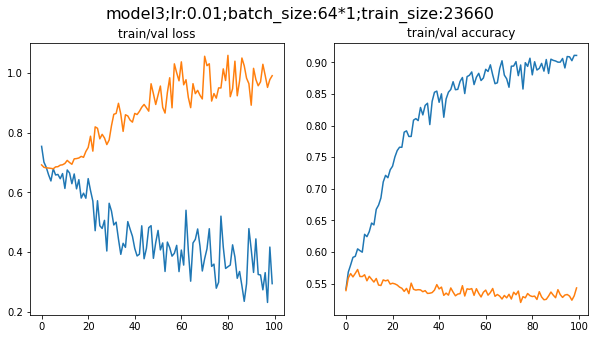

In [6]:
#@title loss plot
plt.rcParams['figure.figsize'] = [10,5]
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle("model3;lr:0.01;batch_size:64*1;train_size:23660",fontsize=16)
loss_train =[ loss.cpu().detach().numpy() for loss in loss_history]


lh = list(filter(lambda x: x < 1, loss_train))
lh = [lh[i] for i in list(range(0,len(lh),369))]
# lh = list(filter(lambda x: x < 1, loss_val))
ax1.plot(lh)
ax1.set_title('train/val loss')
ax1.plot(loss_val,color='tab:orange')
ax2.plot(acc_train)
ax2.set_title('train/val accuracy')
ax2.plot(acc_val,color='tab:orange')


In [ ]:
#@title total parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_max)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|  demb.l1.weight  |   393216   |
|   demb.l1.bias   |    512     |
| demb.bn1.weight  |    512     |
|  demb.bn1.bias   |    512     |
|  pemb.l1.weight  |   98304    |
|   pemb.l1.bias   |    256     |
| pemb.bn1.weight  |    256     |
|  pemb.bn1.bias   |    256     |
| decoder.0.weight |   393216   |
|  decoder.0.bias  |    512     |
| decoder.2.weight |    512     |
|  decoder.2.bias  |    512     |
| decoder.3.weight |   32768    |
|  decoder.3.bias  |     64     |
| decoder.5.weight |     64     |
|  decoder.5.bias  |     64     |
| decoder.6.weight |    2048    |
|  decoder.6.bias  |     32     |
| decoder.8.weight |     32     |
|  decoder.8.bias  |     1      |
+------------------+------------+
Total Trainable Params: 923649


923649

In [ ]:
#@title define configurations
config = BIN_config_DBPE()

lr = config['learning_rate']
BATCH_SIZE = config['batch_size']
train_epoch = config['train_epoch']
accumulation_steps = config['accumulation_steps']

print("learning rate:",lr)
print("batch size:",BATCH_SIZE)
print("training epoch:",train_epoch)
print("accumulation steps:", accumulation_steps)


loss_history = []
loss_history_val = []

model = BIN_Interaction_Flat(**config)

if use_cuda:
  model = model.cuda()

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model, dim = 0)
elif torch.cuda.device_count() < 1:
  print("Let's use cpu!")

opt = torch.optim.Adam(model.parameters(), lr = lr)

learning rate: 0.0001
batch size: 64
training epoch: 500
accumulation steps: 10


In [ ]:
#@title import data
print('--- Data Preparation ---')
params = {'batch_size': BATCH_SIZE,
  'shuffle': True,
  'num_workers': 6, 
  'drop_last': True}
dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
df = pd.read_pickle(dataFolder + '/train_loc0.pkl')
df_train, df_val = train_test_split(df, test_size=0.2)

training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train)
training_generator = data.DataLoader(training_set, **params)


--- Data Preparation ---


In [3]:
dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
df1 = pd.read_pickle(dataFolder + 'AP2A_test.pkl')
df1

,loc,dna,label,protein,dna_embedding,protein_embedding
0,>chr1:46269501-46269601_shuf,TGCACGGCGGAGCCGGCCTCCGCAATGCGTGCCCGGCCCGTGCTGC...,0,AP2A,"[[tensor(-0.2545), tensor(-1.1461), tensor(1.9...","[[-30.172863, -10.496992, 86.36631, 16.755226,..."
1,>chr12:133263989-133264089,TCAAGAGGCGCGCTCCGCCCCTCCCCCGCCCCCCGAGGCGCTCCAA...,1,AP2A,"[[tensor(0.3619), tensor(-0.0255), tensor(-1.0...","[[-30.167542, -10.492926, 86.37228, 16.762302,..."
2,>chr22:37593175-37593275_shuf,TCAACTTGATGCTCTGCCAACCCAGAGGGCAAGGGGGATTAGAACC...,0,AP2A,"[[tensor(0.1183), tensor(0.1185), tensor(-1.11...","[[-20.186104, 26.972698, -42.055893, 2.5008981..."
3,>chr17:80208886-80208986,CTCGTGGGCACCACGACCATGTGGCACAGCGAATGGGAATGCGCAC...,1,AP2A,"[[tensor(-0.0361), tensor(-0.8620), tensor(0.7...","[[-30.167542, -10.492926, 86.37228, 16.762302,..."
4,>chr12:96825025-96825125_shuf,GGAGGCAACAGGAGAAGAGGTAGTGGAAGGTAAGAAGGAAGGTGGC...,0,AP2A,"[[tensor(-0.8833), tensor(-0.3277), tensor(0.6...","[[-20.186108, 26.972656, -42.055893, 2.5009115..."
...,...,...,...,...,...,...
7389,>chr12:93964945-93965045,GCACAGCCTCAGGATACCCCGTGCCCGCAGCTCGGGCGCCCGCGGC...,1,AP2A,"[[tensor(-1.5224), tensor(-0.9559), tensor(1.3...","[[-20.186108, 26.972656, -42.055893, 2.5009115..."
7390,>chr18:45494536-45494636,ACCCTAAATCACATTGTTAGACTATCTGGAGTGACCCAAGGCACTC...,1,AP2A,"[[tensor(0.6827), tensor(-1.2677), tensor(-1.1...","[[-30.167542, -10.492926, 86.37228, 16.762302,..."
7391,>chr3:134204549-134204649,ACAGGCCGTCCCTCAGCTGCGGCTTCCTGCCTCAGGCAGGATGTAC...,1,AP2A,"[[tensor(-0.2463), tensor(0.0003), tensor(-1.3...","[[-30.167542, -10.492926, 86.37228, 16.762302,..."
7392,>chr16:29836592-29836692,GAAGTTGGGTGGATGAGTGGATCTGGGGAGCAGGGGCCAAGCCTGA...,1,AP2A,"[[tensor(0.0367), tensor(-0.1440), tensor(0.48...","[[-20.186104, 26.972698, -42.055893, 2.5008981..."


In [13]:
np.mean(df1.protein_embedding[2],0)
# np.mean(df1.protein_embedding[0],0).shape

# torch.mean(df_train.dna_embedding[1],1)
# df_train.dna_embedding[1]
# df_train.shape

array([ 2.72474270e+01,  1.94261017e+01,  3.16818447e+01,  2.61945572e+01,
        4.93630505e+00,  2.88548183e+01,  5.32391510e+01,  5.11433363e+00,
        5.30914497e+01, -4.67658669e-01,  3.23271751e+01,  2.59690475e+01,
        5.10427933e+01,  8.17041302e+00,  2.62861753e+00,  3.18373513e+00,
        6.14768066e+01,  4.20012856e+01,  1.39204607e+01,  9.57683029e+01,
        7.15247269e+01,  1.69385872e+01,  3.28646660e+01, -6.52385235e-01,
        5.09144306e-01,  1.71958237e+01,  8.92241516e+01,  3.98124580e+01,
        2.81149139e+01,  3.14567032e+01, -9.74705315e+00,  3.35254822e+01,
       -9.98736095e+00,  2.00740547e+01,  7.95193863e+00,  8.22505951e+00,
        2.29431019e+01,  2.87653828e+01,  6.57051706e+00, -2.03486462e+01,
        9.05561676e+01,  2.51319695e+01, -4.99575138e+00,  9.26465149e+01,
       -3.48928662e+03,  1.43617802e+01,  5.40350227e+01,  4.73154106e+01,
        4.91893539e+01,  1.07471466e+02,  2.12962971e+01,  4.90958290e+01,
        2.42263222e+01,  

In [7]:
df1.protein_embedding[2]

array([[-2.0186104e+01,  2.6972698e+01, -4.2055893e+01, ...,
        -1.9898030e+03,  7.7662311e+00,  1.8435698e+01],
       [ 9.3969259e+00, -1.8718648e-01, -4.6260705e+00, ...,
        -2.6276663e+03, -2.1458220e+01,  1.2331333e+01],
       [-5.8022790e+00,  7.2602730e+01, -3.4618668e+01, ...,
        -3.1940386e+03,  6.6911148e+01,  8.8883423e+01],
       ...,
       [-5.8207962e+01, -1.4634252e-01,  5.8878094e+01, ...,
        -2.9482605e+03,  1.3981899e+01, -2.1234919e+01],
       [-5.8207962e+01, -1.4634252e-01,  5.8878094e+01, ...,
        -2.9482605e+03,  1.3981899e+01, -2.1234919e+01],
       [-5.8207977e+01, -1.4636159e-01,  5.8878105e+01, ...,
        -2.9482607e+03,  1.3981879e+01, -2.1234911e+01]], dtype=float32)

In [ ]:
file = files[0]
print(file)
df1 = pd.read_pickle(dataFolder + file)
df1

Label0_TCAATATTTTGCTGATTGAATTTAGTTTCCCTGTTCCATTATCTGAAGAGGCCTGGGACGTGGGATTTCAACATCTTTGGTTGCCTTAAACTT


tensor([[-1.2271e+00, -3.5486e-01,  2.2246e-02,  ..., -1.1064e+00,
         -1.3647e+00, -1.3455e-01],
        [-1.2310e+00, -3.5493e-01,  3.9212e-03,  ..., -1.0964e+00,
         -1.3682e+00, -1.3454e-01],
        [-1.2321e+00, -3.5506e-01,  4.2392e-03,  ..., -1.0968e+00,
         -1.3678e+00, -1.3280e-01],
        ...,
        [-1.2355e+00, -3.5438e-01,  6.9817e-03,  ..., -1.0961e+00,
         -1.3674e+00, -1.2779e-01],
        [-1.2365e+00, -3.5423e-01,  5.7010e-03,  ..., -1.0952e+00,
         -1.3680e+00, -1.2630e-01],
        [-1.2365e+00, -3.5390e-01,  1.1665e-03,  ..., -1.0893e+00,
         -1.3727e+00, -1.2243e-01]])

In [ ]:
# torch.mean(df_train.dna_embedding[200],1)
df_train.dna_embedding[200]

tensor([[-1.2271e+00, -3.5486e-01,  2.2246e-02,  ..., -1.1064e+00,
         -1.3647e+00, -1.3455e-01],
        [-1.2310e+00, -3.5494e-01,  3.9210e-03,  ..., -1.0964e+00,
         -1.3682e+00, -1.3454e-01],
        [-1.2321e+00, -3.5505e-01,  4.2388e-03,  ..., -1.0968e+00,
         -1.3678e+00, -1.3280e-01],
        ...,
        [-1.2355e+00, -3.5438e-01,  6.9819e-03,  ..., -1.0961e+00,
         -1.3674e+00, -1.2779e-01],
        [-1.2365e+00, -3.5423e-01,  5.7008e-03,  ..., -1.0952e+00,
         -1.3680e+00, -1.2630e-01],
        [-1.2365e+00, -3.5390e-01,  1.1674e-03,  ..., -1.0894e+00,
         -1.3727e+00, -1.2243e-01]])

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=2d42a576120ba4915c70b22c3b3792b9bab08de015a8bce09762349d1d93ae78
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


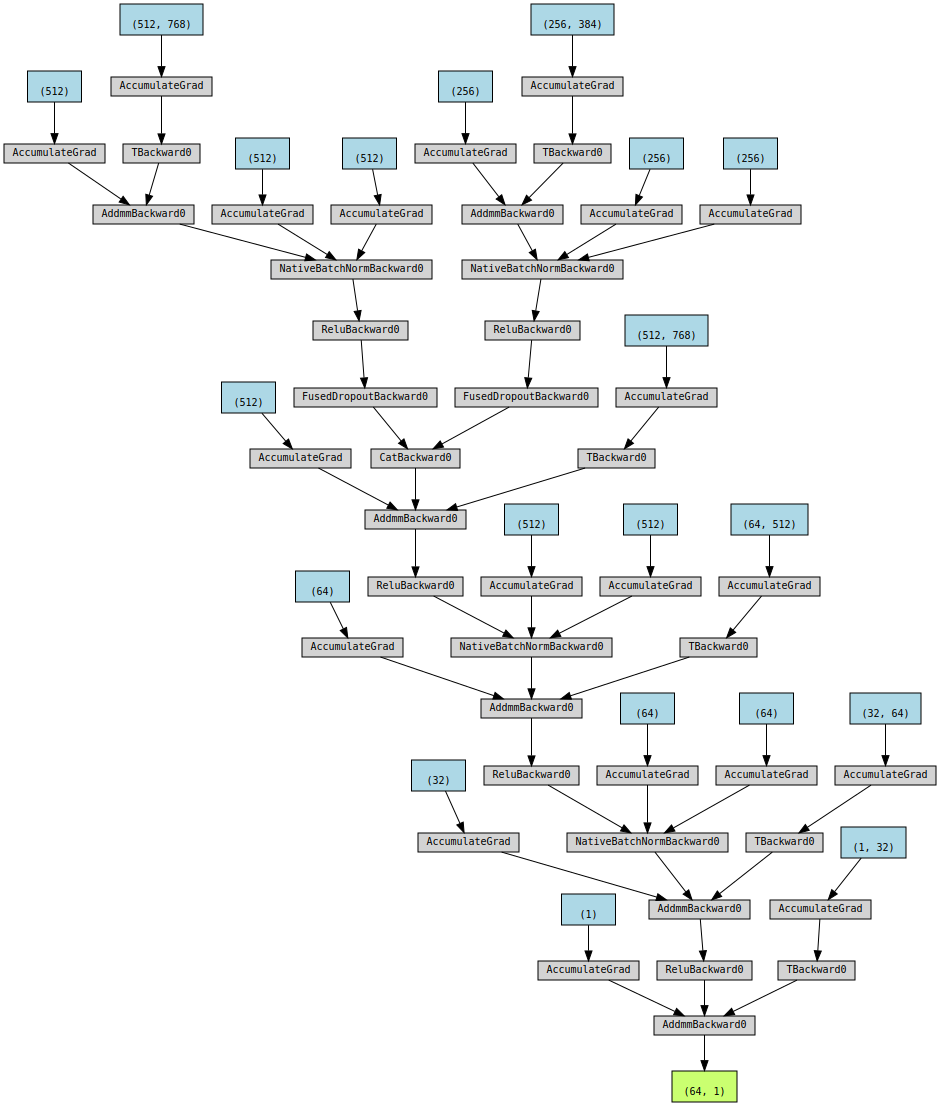

In [ ]:
#@title model structure
!pip install torchviz
from torchviz import make_dot
batch = next(iter(training_generator))
d, p, targets = batch[0], batch[1], batch[2]
d = d.cuda()
p = p.cuda() 
# make_dot(model(d,p),params=dict(list(model.named_parameters)))
make_dot(model(d,p))


In [ ]:
train.label.sum()
train.shape
test.shape
test.label.sum()

487

In [ ]:
with torch.set_grad_enabled(False):
    auc, auprc, f1, logits, loss = test(training_generator, model_max, use_cuda)
    print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))

optimal threshold: 0.5
AUROC:0.6595319721727312
AUPRC: 0.663322982355117
Confusion Matrix : 
 [[320 131]
 [231 278]]
Recall :  0.5461689587426326
Precision :  0.6797066014669927
Accuracy :  0.6229166666666667
Sensitivity :  0.7095343680709535
Specificity :  0.5461689587426326
Testing AUROC: 0.6595319721727312 , AUPRC: 0.663322982355117 , F1: 0.6056644880174293 , Test loss: 1.774868130683899


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#@title train model
print('--- Go for Training ---')
torch.backends.cudnn.benchmark = True
for epo in range(1000):
    model.train()
    for i, (d, p, label) in enumerate(training_generator):
        
        label = Variable(torch.from_numpy(np.array(label)).float())
        if use_cuda:
            d = d.cuda()
            p = p.cuda()
            label = label.cuda()

        
        score = model(d, p)
        loss_fct = torch.nn.BCELoss()
        m = torch.nn.Sigmoid()
        n = torch.squeeze(m(score))
        # print(d.isnan().any())
        # print(p.isnan().any())
        # print(p)
        
        loss = loss_fct(n, label)
        loss_history.append(loss)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
  
        print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
        

--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.7160621
Training at Epoch 2 iteration 0 with loss 0.70942146
Training at Epoch 3 iteration 0 with loss 0.69520783
Training at Epoch 4 iteration 0 with loss 0.7019872
Training at Epoch 5 iteration 0 with loss 0.6908716
Training at Epoch 6 iteration 0 with loss 0.67784256
Training at Epoch 7 iteration 0 with loss 0.7078518
Training at Epoch 8 iteration 0 with loss 0.7020625
Training at Epoch 9 iteration 0 with loss 0.6767439
Training at Epoch 10 iteration 0 with loss 0.6813489
Training at Epoch 11 iteration 0 with loss 0.69095546
Training at Epoch 12 iteration 0 with loss 0.6821579
Training at Epoch 13 iteration 0 with loss 0.68481475
Training at Epoch 14 iteration 0 with loss 0.6866348
Training at Epoch 15 iteration 0 with loss 0.6909596
Training at Epoch 16 iteration 0 with loss 0.6863352
Training at Epoch 17 iteration 0 with loss 0.6871693
Training at Epoch 18 iteration 0 with loss 0.68436444
Training at Epoch 19 iter

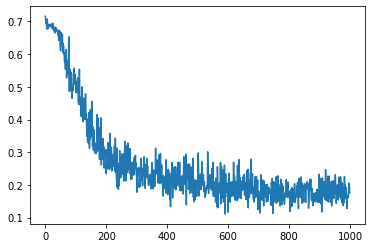

In [ ]:
#@title training loss plot
loss_history =[ loss.detach().numpy() for loss in loss_history]
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)

In [ ]:
#@title validation loss
print('--- Data preparation ---')
df_val = pd.read_pickle(dataFolder + '/val_loc0.pkl')[2000:2200]
validation_set = BIN_Data_Encoder(np.array([i for i in range(df_val.shape[0])]), df_val.label.values, df_val, max_d, max_p)
validation_generator = data.DataLoader(validation_set, **params)

print('--- Go for validation ---')
try:
    with torch.set_grad_enabled(False):
        auc, auprc, f1, logits, loss = test(validation_generator, model, use_cuda)
        print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
except:
    print('testing failed')

--- Data preparation ---
--- Go for validation ---
optimal threshold: 2.55142236227357e-08
AUROC:0.48966376089663755
AUPRC: 0.41557115475169115
Confusion Matrix : 
 [[ 2 71]
 [ 0 55]]
Recall :  1.0
Precision :  0.4365079365079365
Accuracy :  0.4453125
Sensitivity :  0.0273972602739726
Specificity :  1.0
Testing AUROC: 0.48966376089663755 , AUPRC: 0.41557115475169115 , F1: 0.38461538461538464 , Test loss: 2.7558815479278564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


learning rate: 0.01
batch size: 64
training epoch: 1000
accumulation steps: 5


AttributeError: ignored

In [ ]:
10000/128

78.125

Text(0.5, 1.0, 'val loss')

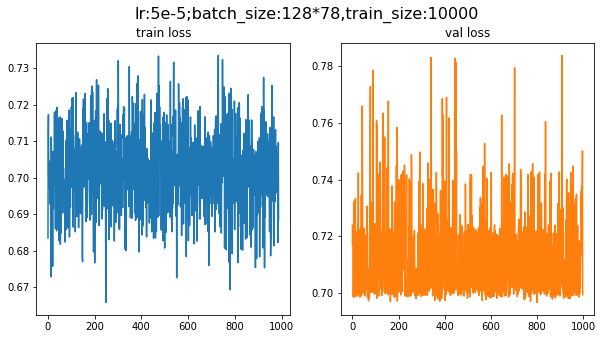

In [ ]:
#@title training loss plot
plt.rcParams['figure.figsize'] = [10,5]
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle("lr:5e-5;batch_size:128*78,train_size:10000",fontsize=16)
loss_train =[ loss.cpu().detach().numpy() for loss in loss_history]


lh = list(filter(lambda x: x < 1, loss_train))
lh = [lh[i] for i in list(range(0,len(lh),78))]
# lh = list(filter(lambda x: x < 1, loss_val))
ax1.plot(lh)
ax1.set_title('train loss')
ax2.plot(loss_val,color='tab:orange')
ax2.set_title('val loss')


In [ ]:
#@title validation loss plot
# loss_history_val =[ loss.cpu().detach().numpy() for loss in loss_history_val]
# loss_history_val =[ loss.cpu().detach().numpy() for loss in loss_history_val]
lh = list(filter(lambda x: x < 1, loss_history_val))
plt.plot(lh)


NameError: ignored

In [ ]:
#@title define torchtest functions
# !pip install --upgrade torchtest
# install from source because I need to make some changes to the source code
# %%bash
# git clone https://github.com/suriyadeepan/torchtest.git --quiet
class VariablesChangeException(Exception):
  pass
def assert_vars_change(model, loss_fn, optim, batch, device, params=None):
  """Make sure that the given parameters (params) DO change during training
  If parameters (params) aren't provided, check all parameters.
  Parameters
  ----------
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 element list of inputs and labels, to be fed to the model
  params : list, optional
    list of parameters of form (name, variable)
  Raises
  ------
  VariablesChangeException
    If params do not change during training
  """

  _var_change_helper(True, model, loss_fn, optim, batch, device, params)

def _var_change_helper(vars_change, model, loss_fn, optim, batch, device, params=None): 
  """Check if given variables (params) change or not during training
  If parameters (params) aren't provided, check all parameters.
  Parameters
  ----------
  vars_change : bool
    a flag which controls the check for change or not change
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 ele## ment list of inputs and labels, to be fed to the model
  params : list, optional
    list of parameters of form (name, variable)
  Raises
  ------
  VariablesChangeException
    if vars_change is True and params DO NOT change during training
    if vars_change is False and params DO change during training
  """

  if params is None:
    # get a list of params that are allowed to change
    params = [ np for np in model.named_parameters() if np[1].requires_grad ]

  # take a copy
  initial_params = [ (name, p.clone()) for (name, p) in params ]

  # run a training step
  _train_step(model, loss_fn, optim, batch, device)

  # check if variables have changed
  for (_, p0), (name, p1) in zip(initial_params, params):
    try:
      if vars_change:
        assert not torch.equal(p0.to(device), p1.to(device))
      else:
        assert torch.equal(p0.to(device), p1.to(device))
    except AssertionError:
      raise VariablesChangeException( # error message
          "{var_name} {msg}".format(
            var_name=name, 
            msg='did not change!' if vars_change else 'changed!' 
            )
          )

def _train_step(model, loss_fn, optim, batch, device):
  """Run a training step on model for a given batch of data
  Parameters of the model accumulate gradients and the optimizer performs
  a gradient update on the parameters
  Parameters
  ----------
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 element list of inputs and labels, to be fed to the model
  """

  # put model in train mode
  model.train()
  model.to(device)

  #  run one forward + backward step
  # clear gradient
  optim.zero_grad()
  # inputs and targets
  inputs_d, inputs_p, targets = batch[0], batch[1], batch[2]
  # move data to DEVICE
  inputs_d = inputs_d.to(device)
  inputs_p = inputs_p.to(device)
  targets = targets.to(device)
  # targets = targets.unsqueeze(1)
  targets = Variable(torch.from_numpy(np.array(targets)).float())
  # forward
  likelihood = model(inputs_d, inputs_p)
  m = torch.nn.Sigmoid()
  likelihood = torch.squeeze(m(likelihood))
  print(likelihood)
  # calc loss
  loss = loss_fn(likelihood, targets)
  # backward
  loss.backward()
  # optimization step
  optim.step()

In [ ]:
#@title unit testing to check if the variables change
# from torchtest.torchtest.torchtest import assert_vars_change
config = BIN_config_DBPE()

lr = 5e-6
BATCH_SIZE = config['batch_size']
train_epoch = 20
max_d = config['max_dna_seq']
max_p = config['max_protein_seq']

loss_history = []

model = BIN_Interaction_Flat(**config)

if use_cuda:
  model = model.cuda()

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model, dim = 0)
elif torch.cuda.device_count() < 1:
  print("Let's use cpu!")

opt = torch.optim.Adam(model.parameters(), lr = lr)
#opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

print('--- Data Preparation ---')

params = {'batch_size': BATCH_SIZE,
  'shuffle': True,
  'num_workers': 6, 
  'drop_last': True}

dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
df_train = pd.read_pickle(dataFolder + '/test_loc0.pkl')
df_train = df_train[1:1000]
training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train, max_d, max_p)
training_generator = data.DataLoader(training_set, **params)
loss_fct = torch.nn.BCELoss()

# check if variables change
assert_vars_change(
    model=model,
    loss_fn=loss_fct,
    optim=opt,
    batch=next(iter(training_generator)),
    device = "cpu")
## the result shows that variables do change, which is normal

Let's use cpu!
--- Data Preparation ---
tensor([0.4965, 0.5717, 0.5185, 0.4198, 0.4027, 0.4152, 0.5024, 0.5175, 0.4390,
        0.4893, 0.4631, 0.4672, 0.4725, 0.6192, 0.4745, 0.5834, 0.5142, 0.4815,
        0.5840, 0.4610, 0.5377, 0.4646, 0.5225, 0.4946, 0.5003, 0.5481, 0.4732,
        0.4424, 0.5784, 0.5626, 0.5347, 0.5471, 0.4890, 0.4901, 0.4970, 0.5333,
        0.4829, 0.5130, 0.4591, 0.4018, 0.4699, 0.5625, 0.5158, 0.5083, 0.5193,
        0.5327, 0.4991, 0.5059, 0.4984, 0.5503, 0.3966, 0.5136, 0.3932, 0.4666,
        0.4188, 0.4501, 0.4586, 0.4803, 0.4674, 0.4960, 0.5039, 0.4941, 0.5242,
        0.4039], grad_fn=<SqueezeBackward0>)


In [ ]:
# max(1,torch.cuda.device_count())
# d = main(1,5e-6, use_cuda)
# device
# batch=next(iter(training_generator))
# len(batch[0])
# batch[2]
# params = [ np for np in model.named_parameters() if np[1].requires_grad ]
# initial_params = [ (name, p.clone()) for (name, p) in params ]
initial_params

[('demb.transform.weight',
  tensor([[-0.0291, -0.0007,  0.0073,  ...,  0.0035,  0.0324,  0.0176],
          [-0.0296,  0.0276, -0.0271,  ...,  0.0228, -0.0101, -0.0187],
          [-0.0299,  0.0059, -0.0350,  ..., -0.0058, -0.0274, -0.0069],
          ...,
          [-0.0303, -0.0323, -0.0282,  ...,  0.0208,  0.0121,  0.0334],
          [ 0.0088,  0.0084,  0.0330,  ..., -0.0084,  0.0066, -0.0153],
          [ 0.0355, -0.0330, -0.0098,  ...,  0.0009, -0.0322,  0.0230]],
         grad_fn=<CloneBackward0>)),
 ('demb.transform.bias',
  tensor([ 6.3124e-03, -2.1090e-02, -3.3061e-03,  3.5418e-02, -2.7279e-02,
          -1.7519e-02, -2.5768e-02,  1.9395e-02,  2.3362e-02, -1.3061e-02,
           1.6543e-02, -1.6530e-02,  1.5928e-03, -1.8415e-02, -2.3893e-02,
           5.5419e-03, -2.5598e-02,  3.4201e-02, -2.3198e-02, -3.5226e-03,
          -2.5163e-02,  3.0936e-02, -2.6849e-02, -1.6872e-02,  2.5944e-02,
          -1.0825e-02,  6.8592e-03,  4.1332e-03, -3.3762e-02,  7.3368e-05,
           2.

yes
10
yes
20
yes
30
yes
40
yes
50
yes
60
yes
70
yes
80
yes
90
yes
100
